# Relational Knowledge Distillation - Wider Dataset

https://arxiv.org/abs/1904.05068

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import boto3
import io
import os

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss
from utils.misc_tools_rkd import best_lr_rkd, rkd_train_teacher, rkd_train_student_with_distillation, rkd_test_model
from utils.compare_tools_rkd import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison


In [2]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 240
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
beta = 0.0
patience = 7  # for early stopping

# batch_size = 32
batch_size = 16
num_workers = 2

# class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
# class_labels_new = torch.tensor([i for i in range(len(class_labels))])

In [3]:
# Load WIDER dataset


train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])


trainloader, testloader  =  load_wider(train_file, test_file, class_labels, 
                                       batch_size, num_workers) 

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [4]:
# # Accessing a single batch from the DataLoader
# batch = next(iter(trainloader))
# batch

In [5]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = CustomResNet18()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# Ensure the final classification layer is added to the model
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
student_model.fc = nn.Linear(student_model.output_size, num_classes)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)


criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
torch.cuda.empty_cache()

In [8]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [9]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"


## Fina the best learning rate

100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:42<00:00,  4.63it/s]


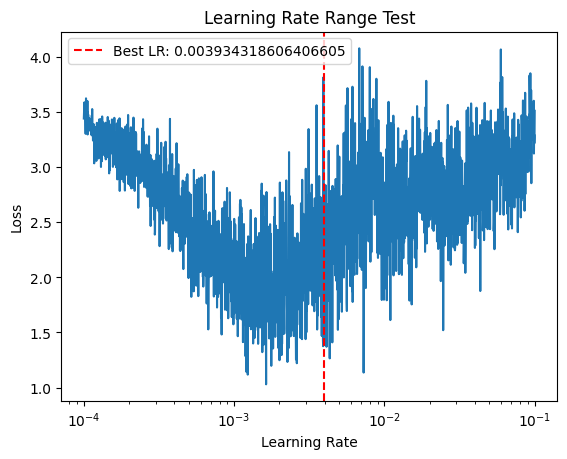

Best learning rate: 0.003934318606406605
0.003934318606406605


In [8]:
teacher_lr = best_lr_rkd(teacher_model, trainloader, criterion, 
                        teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(teacher_lr)

100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.25it/s]


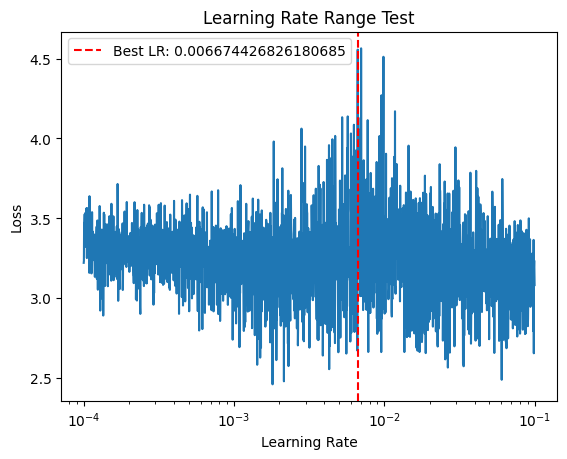

Best learning rate: 0.006674426826180685
0.006674426826180685


In [9]:
studnet_lr = best_lr_rkd(student_model, trainloader, criterion, 
                         student_optimizer, student_scheduler, device, num_epochs=3)  
print(studnet_lr)

In [10]:
teacher_lr = 0.003934318606406605
student_lr = 0.006674426826180685

In [11]:
# Ensure the final classification layer is added to the model
# num_class = 30
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
student_model.fc = nn.Linear(student_model.output_size, num_classes)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_lr, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_lr, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Training Teacher and Student Models

In [12]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [13]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
rkd_train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)


 13%|█████████▌                                                              | 100/754 [00:22<02:10,  5.02it/s]

[1, 100] loss: 3.345


 27%|███████████████████                                                     | 200/754 [00:44<01:55,  4.80it/s]

[1, 200] loss: 3.275


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:37,  4.65it/s]

[1, 300] loss: 3.240


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:24,  4.17it/s]

[1, 400] loss: 3.180


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:49,  5.14it/s]

[1, 500] loss: 3.147


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:30,  5.06it/s]

[1, 600] loss: 3.147


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:11,  4.80it/s]

[1, 700] loss: 3.102


 13%|█████████▋                                                              | 101/754 [00:22<02:21,  4.62it/s]

[2, 100] loss: 3.061


 27%|███████████████████▏                                                    | 201/754 [00:44<01:55,  4.78it/s]

[2, 200] loss: 3.036


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:31,  4.95it/s]

[2, 300] loss: 3.001


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:15,  4.67it/s]

[2, 400] loss: 2.977


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:49<00:51,  4.94it/s]

[2, 500] loss: 2.919


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:28,  5.28it/s]

[2, 600] loss: 2.964


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:10,  5.19it/s]

[2, 700] loss: 2.926


 13%|█████████▋                                                              | 101/754 [00:22<02:10,  5.01it/s]

[3, 100] loss: 2.872


 27%|███████████████████                                                     | 200/754 [00:44<02:02,  4.51it/s]

[3, 200] loss: 2.872


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:28,  5.11it/s]

[3, 300] loss: 2.862


 53%|██████████████████████████████████████▏                                 | 400/754 [01:29<01:18,  4.51it/s]

[3, 400] loss: 2.823


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:50<00:49,  5.15it/s]

[3, 500] loss: 2.812


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:13<00:33,  4.53it/s]

[3, 600] loss: 2.818


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:36<00:12,  4.40it/s]

[3, 700] loss: 2.755


 13%|█████████▌                                                              | 100/754 [00:23<02:10,  5.02it/s]

[4, 100] loss: 2.794


 27%|███████████████████                                                     | 200/754 [00:45<02:06,  4.37it/s]

[4, 200] loss: 2.784


 40%|████████████████████████████▋                                           | 300/754 [01:09<01:43,  4.39it/s]

[4, 300] loss: 2.742


 53%|██████████████████████████████████████▏                                 | 400/754 [01:32<01:08,  5.18it/s]

[4, 400] loss: 2.733


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:56<00:51,  4.90it/s]

[4, 500] loss: 2.728


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:18<00:33,  4.63it/s]

[4, 600] loss: 2.697


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:40<00:10,  5.14it/s]

[4, 700] loss: 2.704


 13%|█████████▋                                                              | 101/754 [00:23<02:24,  4.52it/s]

[5, 100] loss: 2.683


 27%|███████████████████                                                     | 200/754 [00:47<01:49,  5.08it/s]

[5, 200] loss: 2.643


 40%|████████████████████████████▋                                           | 300/754 [01:10<01:54,  3.95it/s]

[5, 300] loss: 2.603


 53%|██████████████████████████████████████▎                                 | 401/754 [01:34<01:15,  4.66it/s]

[5, 400] loss: 2.621


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:58<00:59,  4.23it/s]

[5, 500] loss: 2.586


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:22<00:34,  4.44it/s]

[5, 600] loss: 2.650


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:46<00:12,  4.43it/s]

[5, 700] loss: 2.627


 13%|█████████▌                                                              | 100/754 [00:22<02:08,  5.09it/s]

[6, 100] loss: 2.524


 27%|███████████████████                                                     | 200/754 [00:45<02:12,  4.17it/s]

[6, 200] loss: 2.573


 40%|████████████████████████████▋                                           | 301/754 [01:09<01:37,  4.64it/s]

[6, 300] loss: 2.563


 53%|██████████████████████████████████████▏                                 | 400/754 [01:32<01:13,  4.80it/s]

[6, 400] loss: 2.472


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:55<00:52,  4.82it/s]

[6, 500] loss: 2.467


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:18<00:30,  5.04it/s]

[6, 600] loss: 2.496


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:41<00:10,  5.03it/s]

[6, 700] loss: 2.480


 13%|█████████▋                                                              | 101/754 [00:24<02:26,  4.45it/s]

[7, 100] loss: 2.411


 27%|███████████████████                                                     | 200/754 [00:46<02:07,  4.34it/s]

[7, 200] loss: 2.368


 40%|████████████████████████████▋                                           | 300/754 [01:09<01:32,  4.92it/s]

[7, 300] loss: 2.437


 53%|██████████████████████████████████████▎                                 | 401/754 [01:31<01:12,  4.90it/s]

[7, 400] loss: 2.424


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:54<00:56,  4.46it/s]

[7, 500] loss: 2.367


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:17<00:35,  4.31it/s]

[7, 600] loss: 2.328


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:41<00:12,  4.36it/s]

[7, 700] loss: 2.364


 13%|█████████▋                                                              | 101/754 [00:23<02:27,  4.44it/s]

[8, 100] loss: 2.307


 27%|███████████████████▏                                                    | 201/754 [00:46<02:10,  4.24it/s]

[8, 200] loss: 2.275


 40%|████████████████████████████▋                                           | 301/754 [01:09<01:33,  4.85it/s]

[8, 300] loss: 2.312


 53%|██████████████████████████████████████▎                                 | 401/754 [01:32<01:13,  4.80it/s]

[8, 400] loss: 2.277


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:56<00:56,  4.50it/s]

[8, 500] loss: 2.271


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:19<00:36,  4.25it/s]

[8, 600] loss: 2.278


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:42<00:12,  4.20it/s]

[8, 700] loss: 2.240


 13%|█████████▋                                                              | 101/754 [00:23<02:37,  4.15it/s]

[9, 100] loss: 2.181


 27%|███████████████████                                                     | 200/754 [00:45<02:00,  4.60it/s]

[9, 200] loss: 2.137


 40%|████████████████████████████▋                                           | 300/754 [01:08<01:42,  4.45it/s]

[9, 300] loss: 2.161


 53%|██████████████████████████████████████▎                                 | 401/754 [01:31<01:16,  4.63it/s]

[9, 400] loss: 2.169


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:54<00:56,  4.53it/s]

[9, 500] loss: 2.138


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:17<00:30,  5.03it/s]

[9, 600] loss: 2.159


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:41<00:12,  4.37it/s]

[9, 700] loss: 2.198


 13%|█████████▌                                                              | 100/754 [00:23<02:17,  4.76it/s]

[10, 100] loss: 2.032


 27%|███████████████████                                                     | 200/754 [00:46<02:01,  4.55it/s]

[10, 200] loss: 2.027


 40%|████████████████████████████▋                                           | 300/754 [01:10<01:41,  4.46it/s]

[10, 300] loss: 2.074


 53%|██████████████████████████████████████▎                                 | 401/754 [01:34<01:09,  5.06it/s]

[10, 400] loss: 2.083


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:57<00:47,  5.29it/s]

[10, 500] loss: 2.067


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:19<00:31,  4.80it/s]

[10, 600] loss: 2.055


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:41<00:10,  5.14it/s]

[10, 700] loss: 2.017


 13%|█████████▌                                                              | 100/754 [00:23<02:15,  4.82it/s]

[11, 100] loss: 1.851


 27%|███████████████████▏                                                    | 201/754 [00:46<02:00,  4.58it/s]

[11, 200] loss: 2.030


 40%|████████████████████████████▋                                           | 300/754 [01:10<01:43,  4.38it/s]

[11, 300] loss: 1.941


 53%|██████████████████████████████████████▎                                 | 401/754 [01:34<01:19,  4.43it/s]

[11, 400] loss: 1.956


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:58<00:55,  4.53it/s]

[11, 500] loss: 1.907


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:20<00:29,  5.30it/s]

[11, 600] loss: 1.957


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:43<00:11,  4.62it/s]

[11, 700] loss: 1.941


 13%|█████████▋                                                              | 101/754 [00:24<02:00,  5.42it/s]

[12, 100] loss: 1.826


 27%|███████████████████▏                                                    | 201/754 [00:48<01:48,  5.09it/s]

[12, 200] loss: 1.834


 40%|████████████████████████████▋                                           | 300/754 [01:11<01:31,  4.97it/s]

[12, 300] loss: 1.876


 53%|██████████████████████████████████████▎                                 | 401/754 [01:34<01:15,  4.66it/s]

[12, 400] loss: 1.853


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:56<00:49,  5.11it/s]

[12, 500] loss: 1.804


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:19<00:35,  4.30it/s]

[12, 600] loss: 1.862


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:43<00:13,  4.00it/s]

[12, 700] loss: 1.828


 13%|█████████▌                                                              | 100/754 [00:24<02:28,  4.41it/s]

[13, 100] loss: 1.696


 27%|███████████████████▏                                                    | 201/754 [00:48<02:04,  4.45it/s]

[13, 200] loss: 1.734


 40%|████████████████████████████▋                                           | 300/754 [01:11<01:39,  4.56it/s]

[13, 300] loss: 1.701


 53%|██████████████████████████████████████▎                                 | 401/754 [01:36<01:15,  4.65it/s]

[13, 400] loss: 1.762


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:59<00:58,  4.36it/s]

[13, 500] loss: 1.722


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:22<00:34,  4.48it/s]

[13, 600] loss: 1.749


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:45<00:10,  5.02it/s]

[13, 700] loss: 1.759


 13%|█████████▋                                                              | 101/754 [00:23<02:17,  4.76it/s]

[14, 100] loss: 1.596


 27%|███████████████████▏                                                    | 201/754 [00:44<01:43,  5.33it/s]

[14, 200] loss: 1.623


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:21,  5.55it/s]

[14, 300] loss: 1.646


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:01,  5.73it/s]

[14, 400] loss: 1.635


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:50,  5.07it/s]

[14, 500] loss: 1.614


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:32,  4.66it/s]

[14, 600] loss: 1.668


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:33<00:11,  4.60it/s]

[14, 700] loss: 1.654


 13%|█████████▌                                                              | 100/754 [00:23<02:15,  4.84it/s]

[15, 100] loss: 1.450


 27%|███████████████████▏                                                    | 201/754 [00:45<01:45,  5.23it/s]

[15, 200] loss: 1.525


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:39,  4.56it/s]

[15, 300] loss: 1.497


 53%|██████████████████████████████████████▏                                 | 400/754 [01:30<01:12,  4.91it/s]

[15, 400] loss: 1.488


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:59,  4.27it/s]

[15, 500] loss: 1.462


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:15<00:30,  5.05it/s]

[15, 600] loss: 1.614


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:37<00:11,  4.61it/s]

[15, 700] loss: 1.603


 13%|█████████▋                                                              | 101/754 [00:22<02:25,  4.48it/s]

[16, 100] loss: 1.352


 27%|███████████████████                                                     | 200/754 [00:44<02:02,  4.52it/s]

[16, 200] loss: 1.407


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:26,  5.24it/s]

[16, 300] loss: 1.359


 53%|██████████████████████████████████████▎                                 | 401/754 [01:29<01:14,  4.75it/s]

[16, 400] loss: 1.383


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<01:02,  4.03it/s]

[16, 500] loss: 1.456


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:15<00:35,  4.30it/s]

[16, 600] loss: 1.469


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:38<00:12,  4.48it/s]

[16, 700] loss: 1.496


 13%|█████████▋                                                              | 101/754 [00:22<02:19,  4.69it/s]

[17, 100] loss: 1.212


 27%|███████████████████▏                                                    | 201/754 [00:44<01:52,  4.89it/s]

[17, 200] loss: 1.344


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:32,  4.92it/s]

[17, 300] loss: 1.359


 53%|██████████████████████████████████████▎                                 | 401/754 [01:29<01:18,  4.48it/s]

[17, 400] loss: 1.296


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:46,  5.44it/s]

[17, 500] loss: 1.397


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:13<00:32,  4.79it/s]

[17, 600] loss: 1.375


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:36<00:09,  5.34it/s]

[17, 700] loss: 1.437


 13%|█████████▋                                                              | 101/754 [00:22<02:20,  4.65it/s]

[18, 100] loss: 1.104


 27%|███████████████████                                                     | 200/754 [00:45<02:03,  4.50it/s]

[18, 200] loss: 1.223


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:31,  4.95it/s]

[18, 300] loss: 1.183


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:19,  4.46it/s]

[18, 400] loss: 1.245


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:50,  5.07it/s]

[18, 500] loss: 1.354


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:15<00:33,  4.63it/s]

[18, 600] loss: 1.255


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:38<00:10,  5.18it/s]

[18, 700] loss: 1.302


 13%|█████████▌                                                              | 100/754 [00:23<02:16,  4.80it/s]

[19, 100] loss: 1.100


 27%|███████████████████                                                     | 200/754 [00:45<01:47,  5.15it/s]

[19, 200] loss: 1.138


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:46,  4.24it/s]

[19, 300] loss: 1.110


 53%|██████████████████████████████████████▎                                 | 401/754 [01:29<01:12,  4.87it/s]

[19, 400] loss: 1.138


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:51<00:55,  4.56it/s]

[19, 500] loss: 1.162


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:35,  4.30it/s]

[19, 600] loss: 1.259


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:35<00:11,  4.68it/s]

[19, 700] loss: 1.221


 13%|█████████▋                                                              | 101/754 [00:23<02:22,  4.58it/s]

[20, 100] loss: 1.027


 27%|███████████████████                                                     | 200/754 [00:45<02:00,  4.59it/s]

[20, 200] loss: 1.022


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:51,  4.05it/s]

[20, 300] loss: 1.020


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:20,  4.38it/s]

[20, 400] loss: 1.128


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:53,  4.72it/s]

[20, 500] loss: 1.134


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:15<00:32,  4.70it/s]

[20, 600] loss: 1.152


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:37<00:11,  4.79it/s]

[20, 700] loss: 1.128


 13%|█████████▋                                                              | 101/754 [00:23<02:08,  5.10it/s]

[21, 100] loss: 0.824


 27%|███████████████████▏                                                    | 201/754 [00:46<01:53,  4.88it/s]

[21, 200] loss: 0.960


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:22,  5.52it/s]

[21, 300] loss: 0.947


 53%|██████████████████████████████████████▏                                 | 400/754 [01:30<01:15,  4.67it/s]

[21, 400] loss: 1.072


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<01:01,  4.12it/s]

[21, 500] loss: 1.019


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:14<00:33,  4.55it/s]

[21, 600] loss: 1.064


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:37<00:14,  3.60it/s]

[21, 700] loss: 1.039


 13%|█████████▋                                                              | 101/754 [00:22<02:16,  4.80it/s]

[22, 100] loss: 0.837


 27%|███████████████████▏                                                    | 201/754 [00:45<02:03,  4.48it/s]

[22, 200] loss: 0.848


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:32,  4.89it/s]

[22, 300] loss: 0.924


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:13,  4.81it/s]

[22, 400] loss: 0.935


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:53<00:55,  4.57it/s]

[22, 500] loss: 0.981


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:15<00:34,  4.52it/s]

[22, 600] loss: 1.028


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:37<00:11,  4.43it/s]

[22, 700] loss: 1.003


 13%|█████████▋                                                              | 101/754 [00:21<02:12,  4.92it/s]

[23, 100] loss: 0.824


 27%|███████████████████▏                                                    | 201/754 [00:43<01:35,  5.81it/s]

[23, 200] loss: 0.792


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:22,  5.52it/s]

[23, 300] loss: 0.852


 53%|██████████████████████████████████████▎                                 | 401/754 [01:25<01:14,  4.71it/s]

[23, 400] loss: 0.877


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:53,  4.76it/s]

[23, 500] loss: 0.828


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:08<00:34,  4.50it/s]

[23, 600] loss: 0.890


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:30<00:11,  4.79it/s]

[23, 700] loss: 0.977


 13%|█████████▋                                                              | 101/754 [00:22<02:19,  4.68it/s]

[24, 100] loss: 0.751


 27%|███████████████████▏                                                    | 201/754 [00:43<01:45,  5.24it/s]

[24, 200] loss: 0.772


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:39,  4.56it/s]

[24, 300] loss: 0.824


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:10,  5.04it/s]

[24, 400] loss: 0.734


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:43,  5.77it/s]

[24, 500] loss: 0.808


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:34,  4.39it/s]

[24, 600] loss: 0.851


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:10,  5.00it/s]

[24, 700] loss: 0.879


 13%|█████████▋                                                              | 101/754 [00:22<02:26,  4.46it/s]

[25, 100] loss: 0.661


 27%|███████████████████                                                     | 200/754 [00:44<01:57,  4.70it/s]

[25, 200] loss: 0.675


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:46,  4.25it/s]

[25, 300] loss: 0.707


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:14,  4.75it/s]

[25, 400] loss: 0.717


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:53,  4.77it/s]

[25, 500] loss: 0.798


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:31,  4.89it/s]

[25, 600] loss: 0.811


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:32<00:12,  4.39it/s]

[25, 700] loss: 0.789


 13%|█████████▋                                                              | 101/754 [00:22<01:55,  5.63it/s]

[26, 100] loss: 0.589


 27%|███████████████████▏                                                    | 201/754 [00:43<01:58,  4.68it/s]

[26, 200] loss: 0.654


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:29,  5.07it/s]

[26, 300] loss: 0.676


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:07,  5.24it/s]

[26, 400] loss: 0.709


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:48<01:02,  4.05it/s]

[26, 500] loss: 0.756


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:33,  4.54it/s]

[26, 600] loss: 0.728


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:31<00:12,  4.19it/s]

[26, 700] loss: 0.747


 13%|█████████▌                                                              | 100/754 [00:21<01:59,  5.47it/s]

[27, 100] loss: 0.508


 27%|███████████████████▏                                                    | 201/754 [00:44<02:31,  3.65it/s]

[27, 200] loss: 0.579


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:29,  5.05it/s]

[27, 300] loss: 0.564


 53%|██████████████████████████████████████▏                                 | 400/754 [01:28<01:22,  4.28it/s]

[27, 400] loss: 0.608


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:55,  4.61it/s]

[27, 500] loss: 0.629


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:30,  4.98it/s]

[27, 600] loss: 0.687


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:32<00:10,  5.14it/s]

[27, 700] loss: 0.732


 13%|█████████▌                                                              | 100/754 [00:22<02:24,  4.52it/s]

[28, 100] loss: 0.553


 27%|███████████████████▏                                                    | 201/754 [00:44<01:53,  4.85it/s]

[28, 200] loss: 0.575


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:24,  5.38it/s]

[28, 300] loss: 0.580


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:06,  5.33it/s]

[28, 400] loss: 0.648


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:47,  5.33it/s]

[28, 500] loss: 0.666


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:09<00:33,  4.57it/s]

[28, 600] loss: 0.586


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:10,  5.24it/s]

[28, 700] loss: 0.622


 13%|█████████▋                                                              | 101/754 [00:22<02:15,  4.83it/s]

[29, 100] loss: 0.523


 27%|███████████████████▏                                                    | 201/754 [00:43<02:05,  4.42it/s]

[29, 200] loss: 0.485


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:41,  4.46it/s]

[29, 300] loss: 0.516


 53%|██████████████████████████████████████▏                                 | 400/754 [01:25<01:16,  4.64it/s]

[29, 400] loss: 0.546


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:46<00:50,  5.08it/s]

[29, 500] loss: 0.531


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:08<00:31,  4.89it/s]

[29, 600] loss: 0.563


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:30<00:11,  4.79it/s]

[29, 700] loss: 0.642


 13%|█████████▌                                                              | 100/754 [00:21<02:16,  4.81it/s]

[30, 100] loss: 0.467


 27%|███████████████████▏                                                    | 201/754 [00:43<02:00,  4.61it/s]

[30, 200] loss: 0.492


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:39,  4.57it/s]

[30, 300] loss: 0.480


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:06,  5.30it/s]

[30, 400] loss: 0.476


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:50,  5.04it/s]

[30, 500] loss: 0.559


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:09<00:30,  5.04it/s]

[30, 600] loss: 0.553


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:31<00:10,  4.86it/s]

[30, 700] loss: 0.539


 13%|█████████▋                                                              | 101/754 [00:22<02:22,  4.59it/s]

[31, 100] loss: 0.370


 27%|███████████████████                                                     | 200/754 [00:43<01:49,  5.07it/s]

[31, 200] loss: 0.287


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:38,  4.63it/s]

[31, 300] loss: 0.344


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:18,  4.54it/s]

[31, 400] loss: 0.282


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:47<00:50,  5.00it/s]

[31, 500] loss: 0.265


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:08<00:30,  5.07it/s]

[31, 600] loss: 0.282


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:29<00:12,  4.44it/s]

[31, 700] loss: 0.244


 13%|█████████▋                                                              | 101/754 [00:21<02:09,  5.04it/s]

[32, 100] loss: 0.255


 27%|███████████████████▏                                                    | 201/754 [00:43<01:44,  5.29it/s]

[32, 200] loss: 0.207


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:40,  4.50it/s]

[32, 300] loss: 0.233


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:16,  4.62it/s]

[32, 400] loss: 0.223


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:53,  4.74it/s]

[32, 500] loss: 0.217


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:08<00:34,  4.49it/s]

[32, 600] loss: 0.222


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:30<00:11,  4.87it/s]

[32, 700] loss: 0.253


 13%|█████████▋                                                              | 101/754 [00:22<02:11,  4.97it/s]

[33, 100] loss: 0.197


 27%|███████████████████                                                     | 200/754 [00:43<01:46,  5.18it/s]

[33, 200] loss: 0.198


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:33,  4.84it/s]

[33, 300] loss: 0.205


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:10,  5.01it/s]

[33, 400] loss: 0.212


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:47<00:57,  4.41it/s]

[33, 500] loss: 0.211


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:30,  4.94it/s]

[33, 600] loss: 0.200


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:30<00:11,  4.69it/s]

[33, 700] loss: 0.215


 13%|█████████▌                                                              | 100/754 [00:21<02:20,  4.67it/s]

[34, 100] loss: 0.204


 27%|███████████████████                                                     | 200/754 [00:43<01:56,  4.75it/s]

[34, 200] loss: 0.166


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:34,  4.83it/s]

[34, 300] loss: 0.168


 53%|██████████████████████████████████████▏                                 | 400/754 [01:28<01:21,  4.34it/s]

[34, 400] loss: 0.203


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:50<00:48,  5.18it/s]

[34, 500] loss: 0.166


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:11<00:33,  4.60it/s]

[34, 600] loss: 0.160


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:34<00:10,  5.28it/s]

[34, 700] loss: 0.169


 13%|█████████▌                                                              | 100/754 [00:23<02:14,  4.85it/s]

[35, 100] loss: 0.146


 27%|███████████████████                                                     | 200/754 [00:45<01:52,  4.92it/s]

[35, 200] loss: 0.158


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:40,  4.50it/s]

[35, 300] loss: 0.174


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:29,  3.95it/s]

[35, 400] loss: 0.147


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:54,  4.64it/s]

[35, 500] loss: 0.154


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:15<00:32,  4.77it/s]

[35, 600] loss: 0.162


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:38<00:11,  4.51it/s]

[35, 700] loss: 0.172


 13%|█████████▋                                                              | 101/754 [00:23<02:15,  4.82it/s]

[36, 100] loss: 0.146


 27%|███████████████████▏                                                    | 201/754 [00:44<01:46,  5.20it/s]

[36, 200] loss: 0.123


 40%|████████████████████████████▋                                           | 300/754 [01:06<01:36,  4.69it/s]

[36, 300] loss: 0.164


 53%|██████████████████████████████████████▏                                 | 400/754 [01:29<01:23,  4.25it/s]

[36, 400] loss: 0.154


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:49,  5.13it/s]

[36, 500] loss: 0.147


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:14<00:30,  4.97it/s]

[36, 600] loss: 0.142


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:36<00:10,  4.83it/s]

[36, 700] loss: 0.130


 13%|█████████▌                                                              | 100/754 [00:22<02:09,  5.06it/s]

[37, 100] loss: 0.132


 27%|███████████████████▏                                                    | 201/754 [00:45<01:52,  4.90it/s]

[37, 200] loss: 0.159


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:30,  5.02it/s]

[37, 300] loss: 0.147


 53%|██████████████████████████████████████▏                                 | 400/754 [01:30<01:16,  4.65it/s]

[37, 400] loss: 0.142


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<00:51,  4.91it/s]

[37, 500] loss: 0.137


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:14<00:28,  5.33it/s]

[37, 600] loss: 0.121


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:36<00:10,  5.10it/s]

[37, 700] loss: 0.121


 13%|█████████▌                                                              | 100/754 [00:22<02:38,  4.13it/s]

[38, 100] loss: 0.129


 27%|███████████████████                                                     | 200/754 [00:45<02:00,  4.59it/s]

[38, 200] loss: 0.132


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:32,  4.91it/s]

[38, 300] loss: 0.135


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:17,  4.57it/s]

[38, 400] loss: 0.136


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:53,  4.78it/s]

[38, 500] loss: 0.152


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:14<00:27,  5.60it/s]

[38, 600] loss: 0.139


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:36<00:10,  5.00it/s]

[38, 700] loss: 0.125


 13%|█████████▌                                                              | 100/754 [00:22<02:14,  4.87it/s]

[39, 100] loss: 0.109


 27%|███████████████████                                                     | 200/754 [00:44<01:52,  4.91it/s]

[39, 200] loss: 0.122


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:47,  4.22it/s]

[39, 300] loss: 0.113


 53%|██████████████████████████████████████▏                                 | 400/754 [01:28<01:12,  4.89it/s]

[39, 400] loss: 0.123


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:54,  4.70it/s]

[39, 500] loss: 0.122


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:14<00:34,  4.39it/s]

[39, 600] loss: 0.119


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:37<00:11,  4.62it/s]

[39, 700] loss: 0.138


 13%|█████████▌                                                              | 100/754 [00:22<02:20,  4.67it/s]

[40, 100] loss: 0.128


 27%|███████████████████▏                                                    | 201/754 [00:44<01:53,  4.85it/s]

[40, 200] loss: 0.133


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:46,  4.28it/s]

[40, 300] loss: 0.133


 53%|██████████████████████████████████████▏                                 | 400/754 [01:29<01:18,  4.50it/s]

[40, 400] loss: 0.112


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<00:55,  4.60it/s]

[40, 500] loss: 0.140


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:29,  5.17it/s]

[40, 600] loss: 0.143


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:35<00:11,  4.86it/s]

[40, 700] loss: 0.114


 13%|█████████▋                                                              | 101/754 [00:22<02:28,  4.41it/s]

[41, 100] loss: 0.112


 27%|███████████████████                                                     | 200/754 [00:43<02:07,  4.35it/s]

[41, 200] loss: 0.114


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:40,  4.51it/s]

[41, 300] loss: 0.119


 53%|██████████████████████████████████████▏                                 | 400/754 [01:28<01:18,  4.52it/s]

[41, 400] loss: 0.123


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:55,  4.60it/s]

[41, 500] loss: 0.118


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:31,  4.78it/s]

[41, 600] loss: 0.112


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:35<00:11,  4.74it/s]

[41, 700] loss: 0.133


 13%|█████████▋                                                              | 101/754 [00:22<02:12,  4.92it/s]

[42, 100] loss: 0.136


 27%|███████████████████                                                     | 200/754 [00:45<02:03,  4.48it/s]

[42, 200] loss: 0.136


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:30,  5.04it/s]

[42, 300] loss: 0.114


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:26,  4.06it/s]

[42, 400] loss: 0.106


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:53<00:49,  5.16it/s]

[42, 500] loss: 0.112


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:14<00:35,  4.37it/s]

[42, 600] loss: 0.136


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:37<00:10,  4.96it/s]

[42, 700] loss: 0.101


 13%|█████████▋                                                              | 101/754 [00:22<02:11,  4.97it/s]

[43, 100] loss: 0.135


 27%|███████████████████▏                                                    | 201/754 [00:44<01:54,  4.83it/s]

[43, 200] loss: 0.119


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:42,  4.41it/s]

[43, 300] loss: 0.103


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:19,  4.46it/s]

[43, 400] loss: 0.122


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:54,  4.69it/s]

[43, 500] loss: 0.117


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:13<00:30,  5.12it/s]

[43, 600] loss: 0.116


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:36<00:11,  4.63it/s]

[43, 700] loss: 0.122


 13%|█████████▋                                                              | 101/754 [00:22<02:33,  4.26it/s]

[44, 100] loss: 0.101


 27%|███████████████████                                                     | 200/754 [00:44<01:48,  5.09it/s]

[44, 200] loss: 0.106


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:25,  5.31it/s]

[44, 300] loss: 0.117


 53%|██████████████████████████████████████▏                                 | 400/754 [01:27<01:15,  4.68it/s]

[44, 400] loss: 0.120


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:49<00:44,  5.66it/s]

[44, 500] loss: 0.116


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:12<00:32,  4.78it/s]

[44, 600] loss: 0.106


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:34<00:11,  4.63it/s]

[44, 700] loss: 0.095


 13%|█████████▋                                                              | 101/754 [00:23<02:30,  4.35it/s]

[45, 100] loss: 0.119


 27%|███████████████████                                                     | 200/754 [00:45<02:04,  4.46it/s]

[45, 200] loss: 0.094


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:31,  4.94it/s]

[45, 300] loss: 0.105


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:22,  4.29it/s]

[45, 400] loss: 0.107


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<00:58,  4.36it/s]

[45, 500] loss: 0.102


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:14<00:32,  4.72it/s]

[45, 600] loss: 0.095


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:37<00:10,  5.18it/s]

[45, 700] loss: 0.080


 13%|█████████▌                                                              | 100/754 [00:22<02:25,  4.49it/s]

[46, 100] loss: 0.087


 27%|███████████████████▏                                                    | 201/754 [00:45<01:48,  5.10it/s]

[46, 200] loss: 0.105


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:38,  4.60it/s]

[46, 300] loss: 0.111


 53%|██████████████████████████████████████▎                                 | 401/754 [01:29<01:15,  4.67it/s]

[46, 400] loss: 0.113


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:48,  5.20it/s]

[46, 500] loss: 0.110


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:31,  4.86it/s]

[46, 600] loss: 0.099


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:35<00:09,  5.47it/s]

[46, 700] loss: 0.095


 13%|█████████▋                                                              | 101/754 [00:23<02:47,  3.91it/s]

[47, 100] loss: 0.103


 27%|███████████████████                                                     | 200/754 [00:46<01:55,  4.79it/s]

[47, 200] loss: 0.102


 40%|████████████████████████████▋                                           | 300/754 [01:08<01:32,  4.88it/s]

[47, 300] loss: 0.113


 53%|██████████████████████████████████████▏                                 | 400/754 [01:29<01:19,  4.47it/s]

[47, 400] loss: 0.102


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:48,  5.19it/s]

[47, 500] loss: 0.101


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:13<00:34,  4.46it/s]

[47, 600] loss: 0.097


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:35<00:11,  4.61it/s]

[47, 700] loss: 0.105


 13%|█████████▌                                                              | 100/754 [00:22<02:13,  4.91it/s]

[48, 100] loss: 0.082


 27%|███████████████████▏                                                    | 201/754 [00:44<01:45,  5.25it/s]

[48, 200] loss: 0.082


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:39,  4.54it/s]

[48, 300] loss: 0.091


 53%|██████████████████████████████████████▏                                 | 400/754 [01:27<01:15,  4.70it/s]

[48, 400] loss: 0.100


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:49<00:47,  5.36it/s]

[48, 500] loss: 0.102


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:11<00:30,  5.13it/s]

[48, 600] loss: 0.087


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:33<00:11,  4.46it/s]

[48, 700] loss: 0.101


 13%|█████████▋                                                              | 101/754 [00:22<02:13,  4.90it/s]

[49, 100] loss: 0.088


 27%|███████████████████                                                     | 200/754 [00:44<02:06,  4.39it/s]

[49, 200] loss: 0.089


 40%|████████████████████████████▋                                           | 300/754 [01:06<01:24,  5.37it/s]

[49, 300] loss: 0.097


 53%|██████████████████████████████████████▏                                 | 400/754 [01:29<01:19,  4.43it/s]

[49, 400] loss: 0.086


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:51<00:49,  5.08it/s]

[49, 500] loss: 0.081


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:29,  5.10it/s]

[49, 600] loss: 0.099


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:34<00:10,  4.86it/s]

[49, 700] loss: 0.091


 13%|█████████▌                                                              | 100/754 [00:21<02:01,  5.36it/s]

[50, 100] loss: 0.093


 27%|███████████████████▏                                                    | 201/754 [00:42<01:37,  5.67it/s]

[50, 200] loss: 0.088


 40%|████████████████████████████▋                                           | 300/754 [01:03<01:33,  4.87it/s]

[50, 300] loss: 0.096


 53%|██████████████████████████████████████▏                                 | 400/754 [01:25<01:17,  4.56it/s]

[50, 400] loss: 0.068


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:46<00:56,  4.50it/s]

[50, 500] loss: 0.084


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:08<00:32,  4.77it/s]

[50, 600] loss: 0.090


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:30<00:11,  4.89it/s]

[50, 700] loss: 0.088


 13%|█████████▌                                                              | 100/754 [00:22<02:03,  5.28it/s]

[51, 100] loss: 0.071


 27%|███████████████████▏                                                    | 201/754 [00:44<01:47,  5.15it/s]

[51, 200] loss: 0.076


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:41,  4.45it/s]

[51, 300] loss: 0.089


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:15,  4.72it/s]

[51, 400] loss: 0.091


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:48<00:49,  5.16it/s]

[51, 500] loss: 0.097


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:32,  4.77it/s]

[51, 600] loss: 0.093


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:30<00:10,  5.16it/s]

[51, 700] loss: 0.082


 13%|█████████▋                                                              | 101/754 [00:23<02:32,  4.27it/s]

[52, 100] loss: 0.103


 27%|███████████████████                                                     | 200/754 [00:45<02:00,  4.60it/s]

[52, 200] loss: 0.086


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:36,  4.68it/s]

[52, 300] loss: 0.092


 53%|██████████████████████████████████████▏                                 | 400/754 [01:30<01:08,  5.16it/s]

[52, 400] loss: 0.075


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<00:54,  4.62it/s]

[52, 500] loss: 0.066


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:33,  4.57it/s]

[52, 600] loss: 0.082


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:34<00:10,  5.12it/s]

[52, 700] loss: 0.075


 13%|█████████▌                                                              | 100/754 [00:22<02:02,  5.36it/s]

[53, 100] loss: 0.079


 27%|███████████████████                                                     | 200/754 [00:44<02:06,  4.38it/s]

[53, 200] loss: 0.088


 40%|████████████████████████████▋                                           | 300/754 [01:04<01:35,  4.75it/s]

[53, 300] loss: 0.082


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:11,  4.93it/s]

[53, 400] loss: 0.086


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:48<00:56,  4.48it/s]

[53, 500] loss: 0.093


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:32,  4.68it/s]

[53, 600] loss: 0.082


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:30<00:12,  4.48it/s]

[53, 700] loss: 0.083


 13%|█████████▌                                                              | 100/754 [00:22<02:23,  4.55it/s]

[54, 100] loss: 0.076


 27%|███████████████████▏                                                    | 201/754 [00:44<01:40,  5.50it/s]

[54, 200] loss: 0.098


 40%|████████████████████████████▋                                           | 300/754 [01:06<01:26,  5.27it/s]

[54, 300] loss: 0.082


 53%|██████████████████████████████████████▎                                 | 401/754 [01:28<01:12,  4.89it/s]

[54, 400] loss: 0.068


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:50<00:54,  4.66it/s]

[54, 500] loss: 0.084


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:29,  5.10it/s]

[54, 600] loss: 0.084


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:34<00:11,  4.85it/s]

[54, 700] loss: 0.078


 13%|█████████▋                                                              | 101/754 [00:22<02:18,  4.72it/s]

[55, 100] loss: 0.069


 27%|███████████████████                                                     | 200/754 [00:44<02:01,  4.55it/s]

[55, 200] loss: 0.081


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:38,  4.61it/s]

[55, 300] loss: 0.079


 53%|██████████████████████████████████████▏                                 | 400/754 [01:28<01:05,  5.44it/s]

[55, 400] loss: 0.078


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:50<00:49,  5.15it/s]

[55, 500] loss: 0.080


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:12<00:32,  4.79it/s]

[55, 600] loss: 0.061


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:34<00:11,  4.64it/s]

[55, 700] loss: 0.076


 13%|█████████▋                                                              | 101/754 [00:22<02:22,  4.57it/s]

[56, 100] loss: 0.093


 27%|███████████████████▏                                                    | 201/754 [00:43<01:56,  4.75it/s]

[56, 200] loss: 0.061


 40%|████████████████████████████▋                                           | 300/754 [01:04<01:28,  5.15it/s]

[56, 300] loss: 0.088


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:08,  5.18it/s]

[56, 400] loss: 0.079


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:49,  5.10it/s]

[56, 500] loss: 0.068


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:30,  4.94it/s]

[56, 600] loss: 0.070


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:30<00:12,  4.32it/s]

[56, 700] loss: 0.068


 13%|█████████▋                                                              | 101/754 [00:22<02:07,  5.12it/s]

[57, 100] loss: 0.071


 27%|███████████████████▏                                                    | 201/754 [00:44<01:50,  4.99it/s]

[57, 200] loss: 0.084


 40%|████████████████████████████▋                                           | 300/754 [01:06<01:28,  5.12it/s]

[57, 300] loss: 0.074


 53%|██████████████████████████████████████▎                                 | 401/754 [01:28<01:17,  4.57it/s]

[57, 400] loss: 0.068


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:49<00:53,  4.75it/s]

[57, 500] loss: 0.076


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:31,  4.85it/s]

[57, 600] loss: 0.088


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:32<00:10,  4.89it/s]

[57, 700] loss: 0.068


 13%|█████████▋                                                              | 101/754 [00:22<02:05,  5.21it/s]

[58, 100] loss: 0.069


 27%|███████████████████                                                     | 200/754 [00:44<01:57,  4.71it/s]

[58, 200] loss: 0.069


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:34,  4.80it/s]

[58, 300] loss: 0.067


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:10,  4.99it/s]

[58, 400] loss: 0.071


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:51,  4.95it/s]

[58, 500] loss: 0.059


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:08<00:32,  4.73it/s]

[58, 600] loss: 0.079


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:28<00:11,  4.72it/s]

[58, 700] loss: 0.080


 13%|█████████▋                                                              | 101/754 [00:20<01:55,  5.64it/s]

[59, 100] loss: 0.065


 27%|███████████████████                                                     | 200/754 [00:41<01:56,  4.75it/s]

[59, 200] loss: 0.090


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:22,  5.53it/s]

[59, 300] loss: 0.074


 53%|██████████████████████████████████████▏                                 | 400/754 [01:23<01:17,  4.55it/s]

[59, 400] loss: 0.068


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:44<00:52,  4.82it/s]

[59, 500] loss: 0.052


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:06<00:34,  4.47it/s]

[59, 600] loss: 0.063


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:27<00:09,  5.34it/s]

[59, 700] loss: 0.072


 13%|█████████▋                                                              | 101/754 [00:20<02:09,  5.02it/s]

[60, 100] loss: 0.067


 27%|███████████████████                                                     | 200/754 [00:41<01:59,  4.63it/s]

[60, 200] loss: 0.053


 40%|████████████████████████████▋                                           | 301/754 [01:03<01:33,  4.85it/s]

[60, 300] loss: 0.074


 53%|██████████████████████████████████████▏                                 | 400/754 [01:23<01:02,  5.69it/s]

[60, 400] loss: 0.072


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:44<00:48,  5.20it/s]

[60, 500] loss: 0.069


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:05<00:30,  5.09it/s]

[60, 600] loss: 0.065


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:25<00:09,  5.70it/s]

[60, 700] loss: 0.072


 13%|█████████▋                                                              | 101/754 [00:22<02:14,  4.85it/s]

[61, 100] loss: 0.054


 27%|███████████████████▏                                                    | 201/754 [00:43<02:03,  4.47it/s]

[61, 200] loss: 0.070


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:28,  5.10it/s]

[61, 300] loss: 0.068


 53%|██████████████████████████████████████▎                                 | 401/754 [01:24<01:09,  5.08it/s]

[61, 400] loss: 0.070


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:45<00:44,  5.66it/s]

[61, 500] loss: 0.068


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:06<00:31,  4.84it/s]

[61, 600] loss: 0.058


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:27<00:11,  4.69it/s]

[61, 700] loss: 0.064


 13%|█████████▋                                                              | 101/754 [00:22<02:16,  4.79it/s]

[62, 100] loss: 0.072


 27%|███████████████████                                                     | 200/754 [00:43<01:59,  4.62it/s]

[62, 200] loss: 0.084


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:30,  4.99it/s]

[62, 300] loss: 0.060


 53%|██████████████████████████████████████▎                                 | 401/754 [01:25<01:13,  4.83it/s]

[62, 400] loss: 0.065


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:46<00:55,  4.54it/s]

[62, 500] loss: 0.059


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:07<00:34,  4.50it/s]

[62, 600] loss: 0.059


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:27<00:10,  4.98it/s]

[62, 700] loss: 0.068


 13%|█████████▌                                                              | 100/754 [00:21<02:19,  4.68it/s]

[63, 100] loss: 0.062


 27%|███████████████████                                                     | 200/754 [00:41<01:52,  4.94it/s]

[63, 200] loss: 0.069


 40%|████████████████████████████▋                                           | 301/754 [01:03<01:28,  5.12it/s]

[63, 300] loss: 0.071


 53%|██████████████████████████████████████▎                                 | 401/754 [01:23<01:08,  5.18it/s]

[63, 400] loss: 0.073


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:44<00:48,  5.21it/s]

[63, 500] loss: 0.060


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:05<00:30,  4.98it/s]

[63, 600] loss: 0.061


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:27<00:10,  5.20it/s]

[63, 700] loss: 0.070


 13%|█████████▋                                                              | 101/754 [00:20<02:02,  5.33it/s]

[64, 100] loss: 0.062


 27%|███████████████████                                                     | 200/754 [00:41<01:51,  4.96it/s]

[64, 200] loss: 0.062


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:37,  4.65it/s]

[64, 300] loss: 0.056


 53%|██████████████████████████████████████▎                                 | 401/754 [01:22<01:11,  4.91it/s]

[64, 400] loss: 0.066


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:43<00:50,  5.05it/s]

[64, 500] loss: 0.058


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:05<00:31,  4.83it/s]

[64, 600] loss: 0.069


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:26<00:09,  5.48it/s]

[64, 700] loss: 0.076


 13%|█████████▋                                                              | 101/754 [00:21<02:14,  4.87it/s]

[65, 100] loss: 0.073


 27%|███████████████████                                                     | 200/754 [00:42<01:46,  5.22it/s]

[65, 200] loss: 0.077


 40%|████████████████████████████▋                                           | 301/754 [01:03<01:31,  4.97it/s]

[65, 300] loss: 0.060


 53%|██████████████████████████████████████▏                                 | 400/754 [01:24<01:06,  5.33it/s]

[65, 400] loss: 0.064


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:46<00:47,  5.29it/s]

[65, 500] loss: 0.053


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:07<00:30,  5.06it/s]

[65, 600] loss: 0.065


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:29<00:10,  5.17it/s]

[65, 700] loss: 0.068


 13%|█████████▋                                                              | 101/754 [00:22<02:09,  5.05it/s]

[66, 100] loss: 0.057


 27%|███████████████████                                                     | 200/754 [00:43<02:02,  4.54it/s]

[66, 200] loss: 0.070


 40%|████████████████████████████▋                                           | 300/754 [01:04<01:38,  4.63it/s]

[66, 300] loss: 0.058


 53%|██████████████████████████████████████▏                                 | 400/754 [01:24<01:13,  4.83it/s]

[66, 400] loss: 0.066


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:45<00:53,  4.72it/s]

[66, 500] loss: 0.067


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:05<00:32,  4.71it/s]

[66, 600] loss: 0.073


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:26<00:09,  5.59it/s]

[66, 700] loss: 0.059


100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:37<00:00,  4.79it/s]

Early stopping
Finished Training Teacher


In [14]:
torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
torch.save(teacher_model, 'teacher_model_rkd_wider.pth')
print('teacher weights and architecture saved and exported')

teacher weights and architecture saved and exported


In [15]:
# Call the function to train the student model with knowledge distillation
rkd_train_student_with_distillation(student_model, teacher_model, trainloader, criterion,
                                    student_optimizer, student_scheduler, device, alpha, 
                                    temperature, num_epochs=num_epochs)

 13%|█████████▌                                                              | 100/754 [00:20<02:10,  5.03it/s]

[1, 100] loss: 5.754


 27%|███████████████████▏                                                    | 201/754 [00:40<01:46,  5.17it/s]

[1, 200] loss: 5.655


 40%|████████████████████████████▋                                           | 301/754 [00:59<01:25,  5.32it/s]

[1, 300] loss: 5.458


 53%|██████████████████████████████████████▏                                 | 400/754 [01:18<01:02,  5.65it/s]

[1, 400] loss: 5.458


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:38<00:51,  4.90it/s]

[1, 500] loss: 5.403


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [01:57<00:25,  5.93it/s]

[1, 600] loss: 5.349


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:17<00:09,  5.46it/s]

[1, 700] loss: 5.386


 13%|█████████▌                                                               | 99/754 [00:20<02:21,  4.61it/s]

[2, 100] loss: 5.373


 27%|███████████████████                                                     | 200/754 [00:40<01:57,  4.71it/s]

[2, 200] loss: 5.334


 40%|████████████████████████████▋                                           | 300/754 [00:58<01:22,  5.52it/s]

[2, 300] loss: 5.257


 53%|██████████████████████████████████████▏                                 | 400/754 [01:17<01:14,  4.76it/s]

[2, 400] loss: 5.294


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:37<00:52,  4.83it/s]

[2, 500] loss: 5.335


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [01:56<00:27,  5.59it/s]

[2, 600] loss: 5.354


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:15<00:09,  5.72it/s]

[2, 700] loss: 5.311


 13%|█████████▌                                                              | 100/754 [00:20<01:55,  5.64it/s]

[3, 100] loss: 5.289


 26%|███████████████████                                                     | 199/754 [00:39<01:36,  5.78it/s]

[3, 200] loss: 5.206


 40%|████████████████████████████▋                                           | 300/754 [00:59<01:40,  4.54it/s]

[3, 300] loss: 5.291


 53%|██████████████████████████████████████▏                                 | 400/754 [01:18<01:10,  5.04it/s]

[3, 400] loss: 5.223


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:37<00:43,  5.87it/s]

[3, 500] loss: 5.196


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [01:57<00:25,  5.98it/s]

[3, 600] loss: 5.178


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:16<00:09,  5.48it/s]

[3, 700] loss: 5.205


 13%|█████████▌                                                              | 100/754 [00:20<03:06,  3.50it/s]

[4, 100] loss: 5.270


 27%|███████████████████▏                                                    | 201/754 [00:38<01:33,  5.91it/s]

[4, 200] loss: 5.205


 40%|████████████████████████████▋                                           | 300/754 [00:57<01:17,  5.82it/s]

[4, 300] loss: 5.153


 53%|██████████████████████████████████████                                  | 399/754 [01:16<01:10,  5.03it/s]

[4, 400] loss: 5.147


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:35<00:50,  5.05it/s]

[4, 500] loss: 5.162


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [01:55<00:30,  5.03it/s]

[4, 600] loss: 5.160


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:15<00:09,  5.46it/s]

[4, 700] loss: 5.126


 13%|█████████▌                                                              | 100/754 [00:19<01:48,  6.00it/s]

[5, 100] loss: 5.127


 27%|███████████████████                                                     | 200/754 [00:39<01:51,  4.99it/s]

[5, 200] loss: 5.064


 40%|████████████████████████████▌                                           | 299/754 [00:59<01:46,  4.25it/s]

[5, 300] loss: 5.146


 53%|██████████████████████████████████████▏                                 | 400/754 [01:18<01:08,  5.14it/s]

[5, 400] loss: 5.096


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:37<00:53,  4.73it/s]

[5, 500] loss: 5.083


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [01:57<00:33,  4.68it/s]

[5, 600] loss: 5.149


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:16<00:10,  5.11it/s]

[5, 700] loss: 5.103


 13%|█████████▌                                                               | 99/754 [00:20<02:22,  4.61it/s]

[6, 100] loss: 5.113


 27%|███████████████████                                                     | 200/754 [00:39<01:38,  5.61it/s]

[6, 200] loss: 5.060


 40%|████████████████████████████▋                                           | 300/754 [00:59<01:15,  6.00it/s]

[6, 300] loss: 5.031


 53%|██████████████████████████████████████▏                                 | 400/754 [01:18<01:08,  5.19it/s]

[6, 400] loss: 5.057


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:39<00:44,  5.73it/s]

[6, 500] loss: 5.045


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [01:57<00:29,  5.29it/s]

[6, 600] loss: 5.125


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:17<00:08,  6.17it/s]

[6, 700] loss: 5.073


 13%|█████████▌                                                              | 100/754 [00:19<01:49,  5.95it/s]

[7, 100] loss: 5.017


 27%|███████████████████                                                     | 200/754 [00:40<01:56,  4.77it/s]

[7, 200] loss: 5.057


 40%|████████████████████████████▋                                           | 300/754 [00:59<01:24,  5.36it/s]

[7, 300] loss: 5.034


 53%|██████████████████████████████████████▎                                 | 401/754 [01:18<01:02,  5.61it/s]

[7, 400] loss: 4.986


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:37<00:43,  5.85it/s]

[7, 500] loss: 5.040


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [01:57<00:32,  4.79it/s]

[7, 600] loss: 5.034


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:16<00:12,  4.54it/s]

[7, 700] loss: 4.962


 13%|█████████▋                                                              | 101/754 [00:20<01:52,  5.83it/s]

[8, 100] loss: 5.024


 27%|███████████████████                                                     | 200/754 [00:40<02:08,  4.32it/s]

[8, 200] loss: 4.935


 40%|████████████████████████████▋                                           | 301/754 [01:00<01:16,  5.90it/s]

[8, 300] loss: 4.936


 53%|██████████████████████████████████████▏                                 | 400/754 [01:19<01:07,  5.24it/s]

[8, 400] loss: 5.060


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:39<00:43,  5.79it/s]

[8, 500] loss: 4.969


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [01:58<00:26,  5.87it/s]

[8, 600] loss: 4.962


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:18<00:11,  4.78it/s]

[8, 700] loss: 4.934


 13%|█████████▌                                                              | 100/754 [00:20<01:55,  5.65it/s]

[9, 100] loss: 4.859


 27%|███████████████████▏                                                    | 201/754 [00:40<01:40,  5.51it/s]

[9, 200] loss: 4.994


 40%|████████████████████████████▋                                           | 300/754 [00:59<01:38,  4.63it/s]

[9, 300] loss: 4.969


 53%|██████████████████████████████████████▏                                 | 400/754 [01:18<00:58,  6.06it/s]

[9, 400] loss: 4.871


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:38<00:47,  5.34it/s]

[9, 500] loss: 4.916


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [01:57<00:24,  6.28it/s]

[9, 600] loss: 4.937


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:16<00:10,  5.33it/s]

[9, 700] loss: 4.971


 13%|█████████▋                                                              | 101/754 [00:20<01:51,  5.85it/s]

[10, 100] loss: 4.869


 26%|███████████████████                                                     | 199/754 [00:39<02:06,  4.38it/s]

[10, 200] loss: 4.912


 40%|████████████████████████████▋                                           | 300/754 [00:59<01:26,  5.24it/s]

[10, 300] loss: 4.904


 53%|██████████████████████████████████████▏                                 | 400/754 [01:19<01:14,  4.73it/s]

[10, 400] loss: 4.842


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:39<00:47,  5.32it/s]

[10, 500] loss: 4.849


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [01:58<00:25,  6.10it/s]

[10, 600] loss: 4.904


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:18<00:11,  4.74it/s]

[10, 700] loss: 4.928


 13%|█████████▋                                                              | 101/754 [00:19<01:41,  6.44it/s]

[11, 100] loss: 4.880


 26%|███████████████████                                                     | 199/754 [00:39<02:06,  4.39it/s]

[11, 200] loss: 4.812


 40%|████████████████████████████▌                                           | 299/754 [00:59<01:29,  5.07it/s]

[11, 300] loss: 4.824


 53%|██████████████████████████████████████▎                                 | 401/754 [01:18<00:56,  6.23it/s]

[11, 400] loss: 4.924


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:38<00:52,  4.82it/s]

[11, 500] loss: 4.859


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [01:57<00:25,  6.08it/s]

[11, 600] loss: 4.774


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:16<00:11,  4.62it/s]

[11, 700] loss: 4.784


 13%|█████████▌                                                              | 100/754 [00:20<02:23,  4.55it/s]

[12, 100] loss: 4.854


 27%|███████████████████                                                     | 200/754 [00:40<01:58,  4.69it/s]

[12, 200] loss: 4.724


 40%|████████████████████████████▌                                           | 299/754 [01:00<01:31,  4.99it/s]

[12, 300] loss: 4.847


 53%|██████████████████████████████████████▎                                 | 401/754 [01:19<01:02,  5.67it/s]

[12, 400] loss: 4.756


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:38<01:00,  4.24it/s]

[12, 500] loss: 4.760


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [01:58<00:35,  4.40it/s]

[12, 600] loss: 4.788


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:17<00:09,  5.79it/s]

[12, 700] loss: 4.749


 13%|█████████▌                                                              | 100/754 [00:20<02:09,  5.04it/s]

[13, 100] loss: 4.752


 27%|███████████████████▏                                                    | 201/754 [00:39<01:36,  5.71it/s]

[13, 200] loss: 4.762


 40%|████████████████████████████▋                                           | 301/754 [00:59<01:17,  5.87it/s]

[13, 300] loss: 4.730


 53%|██████████████████████████████████████▏                                 | 400/754 [01:18<01:17,  4.58it/s]

[13, 400] loss: 4.722


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:38<00:50,  5.01it/s]

[13, 500] loss: 4.802


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [01:57<00:27,  5.66it/s]

[13, 600] loss: 4.784


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:16<00:09,  5.52it/s]

[13, 700] loss: 4.722


 13%|█████████▌                                                              | 100/754 [00:20<02:15,  4.84it/s]

[14, 100] loss: 4.635


 27%|███████████████████                                                     | 200/754 [00:39<01:39,  5.56it/s]

[14, 200] loss: 4.682


 40%|████████████████████████████▋                                           | 301/754 [00:58<01:15,  5.98it/s]

[14, 300] loss: 4.772


 53%|██████████████████████████████████████▏                                 | 400/754 [01:18<01:03,  5.59it/s]

[14, 400] loss: 4.651


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:37<00:53,  4.76it/s]

[14, 500] loss: 4.738


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [01:57<00:28,  5.46it/s]

[14, 600] loss: 4.666


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:16<00:10,  5.29it/s]

[14, 700] loss: 4.736


 13%|█████████▋                                                              | 101/754 [00:20<01:55,  5.64it/s]

[15, 100] loss: 4.596


 27%|███████████████████                                                     | 200/754 [00:40<01:56,  4.75it/s]

[15, 200] loss: 4.671


 40%|████████████████████████████▋                                           | 300/754 [00:59<01:14,  6.09it/s]

[15, 300] loss: 4.634


 53%|██████████████████████████████████████▎                                 | 401/754 [01:19<00:58,  6.05it/s]

[15, 400] loss: 4.618


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:39<00:45,  5.52it/s]

[15, 500] loss: 4.623


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [01:59<00:27,  5.64it/s]

[15, 600] loss: 4.759


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:19<00:13,  4.15it/s]

[15, 700] loss: 4.685


 13%|█████████▌                                                               | 99/754 [00:20<02:17,  4.75it/s]

[16, 100] loss: 4.639


 27%|███████████████████                                                     | 200/754 [00:39<01:57,  4.71it/s]

[16, 200] loss: 4.620


 40%|████████████████████████████▌                                           | 299/754 [00:59<01:30,  5.03it/s]

[16, 300] loss: 4.575


 53%|██████████████████████████████████████▏                                 | 400/754 [01:19<01:11,  4.98it/s]

[16, 400] loss: 4.683


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:40<00:52,  4.83it/s]

[16, 500] loss: 4.642


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:00<00:28,  5.42it/s]

[16, 600] loss: 4.581


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:20<00:10,  5.09it/s]

[16, 700] loss: 4.662


 13%|█████████▌                                                              | 100/754 [00:21<02:02,  5.35it/s]

[17, 100] loss: 4.539


 27%|███████████████████                                                     | 200/754 [00:42<02:15,  4.07it/s]

[17, 200] loss: 4.545


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:13,  6.17it/s]

[17, 300] loss: 4.563


 53%|██████████████████████████████████████▏                                 | 400/754 [01:23<01:17,  4.58it/s]

[17, 400] loss: 4.585


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:43<00:43,  5.81it/s]

[17, 500] loss: 4.612


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:03<00:29,  5.33it/s]

[17, 600] loss: 4.538


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:23<00:10,  5.26it/s]

[17, 700] loss: 4.527


 13%|█████████▌                                                               | 99/754 [00:20<02:31,  4.33it/s]

[18, 100] loss: 4.563


 27%|███████████████████                                                     | 200/754 [00:40<01:50,  5.01it/s]

[18, 200] loss: 4.530


 40%|████████████████████████████▋                                           | 301/754 [01:00<01:16,  5.96it/s]

[18, 300] loss: 4.547


 53%|██████████████████████████████████████▏                                 | 400/754 [01:20<00:58,  6.07it/s]

[18, 400] loss: 4.571


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:41<00:48,  5.19it/s]

[18, 500] loss: 4.475


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:00<00:29,  5.16it/s]

[18, 600] loss: 4.526


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:21<00:09,  5.64it/s]

[18, 700] loss: 4.544


 13%|█████████▋                                                              | 101/754 [00:21<01:53,  5.73it/s]

[19, 100] loss: 4.454


 27%|███████████████████▏                                                    | 201/754 [00:43<01:58,  4.66it/s]

[19, 200] loss: 4.491


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:24,  5.37it/s]

[19, 300] loss: 4.566


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:35,  3.70it/s]

[19, 400] loss: 4.484


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<01:08,  3.69it/s]

[19, 500] loss: 4.485


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:10<00:32,  4.75it/s]

[19, 600] loss: 4.514


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:33<00:12,  4.25it/s]

[19, 700] loss: 4.476


 13%|█████████▋                                                              | 101/754 [00:23<02:06,  5.18it/s]

[20, 100] loss: 4.402


 27%|███████████████████                                                     | 200/754 [00:44<01:37,  5.68it/s]

[20, 200] loss: 4.427


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:22,  5.48it/s]

[20, 300] loss: 4.417


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:10,  4.98it/s]

[20, 400] loss: 4.375


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:48<01:00,  4.18it/s]

[20, 500] loss: 4.450


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:32,  4.74it/s]

[20, 600] loss: 4.492


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:09,  5.68it/s]

[20, 700] loss: 4.436


 13%|█████████▌                                                              | 100/754 [00:22<02:45,  3.96it/s]

[21, 100] loss: 4.408


 27%|███████████████████                                                     | 200/754 [00:43<01:45,  5.26it/s]

[21, 200] loss: 4.404


 40%|████████████████████████████▌                                           | 299/754 [01:05<01:22,  5.48it/s]

[21, 300] loss: 4.447


 53%|██████████████████████████████████████▏                                 | 400/754 [01:27<01:13,  4.79it/s]

[21, 400] loss: 4.354


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:45,  5.53it/s]

[21, 500] loss: 4.379


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:29,  5.13it/s]

[21, 600] loss: 4.355


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:31<00:10,  5.27it/s]

[21, 700] loss: 4.403


 13%|█████████▌                                                              | 100/754 [00:22<02:41,  4.05it/s]

[22, 100] loss: 4.327


 27%|███████████████████                                                     | 200/754 [00:44<01:59,  4.63it/s]

[22, 200] loss: 4.378


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:29,  5.05it/s]

[22, 300] loss: 4.376


 53%|██████████████████████████████████████▎                                 | 401/754 [01:28<01:13,  4.81it/s]

[22, 400] loss: 4.301


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:49<00:52,  4.79it/s]

[22, 500] loss: 4.296


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:10<00:30,  5.07it/s]

[22, 600] loss: 4.400


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:09,  5.65it/s]

[22, 700] loss: 4.347


 13%|█████████▋                                                              | 101/754 [00:22<01:54,  5.69it/s]

[23, 100] loss: 4.283


 27%|███████████████████▏                                                    | 201/754 [00:44<01:48,  5.10it/s]

[23, 200] loss: 4.319


 40%|████████████████████████████▋                                           | 300/754 [01:06<01:31,  4.98it/s]

[23, 300] loss: 4.251


 53%|██████████████████████████████████████                                  | 399/754 [01:27<01:15,  4.70it/s]

[23, 400] loss: 4.226


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:49<00:55,  4.58it/s]

[23, 500] loss: 4.358


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:09<00:31,  4.87it/s]

[23, 600] loss: 4.254


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:30<00:12,  4.42it/s]

[23, 700] loss: 4.296


 13%|█████████▌                                                              | 100/754 [00:23<02:08,  5.08it/s]

[24, 100] loss: 4.260


 27%|███████████████████▏                                                    | 201/754 [00:44<01:41,  5.45it/s]

[24, 200] loss: 4.197


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:23,  5.42it/s]

[24, 300] loss: 4.331


 53%|██████████████████████████████████████                                  | 399/754 [01:28<01:15,  4.68it/s]

[24, 400] loss: 4.120


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:49<00:47,  5.29it/s]

[24, 500] loss: 4.307


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:10<00:30,  5.11it/s]

[24, 600] loss: 4.310


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:31<00:09,  5.54it/s]

[24, 700] loss: 4.218


 13%|█████████▌                                                               | 99/754 [00:21<02:19,  4.71it/s]

[25, 100] loss: 4.192


 27%|███████████████████                                                     | 200/754 [00:44<01:54,  4.85it/s]

[25, 200] loss: 4.183


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:27,  5.17it/s]

[25, 300] loss: 4.201


 53%|██████████████████████████████████████▏                                 | 400/754 [01:28<01:22,  4.29it/s]

[25, 400] loss: 4.263


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:49<00:47,  5.39it/s]

[25, 500] loss: 4.216


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:11<00:32,  4.68it/s]

[25, 600] loss: 4.171


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:33<00:11,  4.87it/s]

[25, 700] loss: 4.122


 13%|█████████▋                                                              | 101/754 [00:22<01:56,  5.62it/s]

[26, 100] loss: 4.151


 27%|███████████████████▏                                                    | 201/754 [00:43<01:43,  5.36it/s]

[26, 200] loss: 4.103


 40%|████████████████████████████▌                                           | 299/754 [01:03<01:25,  5.34it/s]

[26, 300] loss: 4.153


 53%|██████████████████████████████████████                                  | 399/754 [01:24<01:18,  4.54it/s]

[26, 400] loss: 4.186


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:45<00:46,  5.51it/s]

[26, 500] loss: 4.085


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:06<00:28,  5.46it/s]

[26, 600] loss: 4.160


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:26<00:09,  5.41it/s]

[26, 700] loss: 4.115


 13%|█████████▌                                                              | 100/754 [00:20<01:58,  5.53it/s]

[27, 100] loss: 4.025


 27%|███████████████████▏                                                    | 201/754 [00:41<01:48,  5.10it/s]

[27, 200] loss: 4.030


 40%|████████████████████████████▋                                           | 301/754 [01:03<01:24,  5.38it/s]

[27, 300] loss: 4.074


 53%|██████████████████████████████████████▏                                 | 400/754 [01:24<01:00,  5.85it/s]

[27, 400] loss: 4.060


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:45<00:49,  5.12it/s]

[27, 500] loss: 4.096


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:06<00:27,  5.55it/s]

[27, 600] loss: 4.106


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:27<00:12,  4.42it/s]

[27, 700] loss: 4.095


 13%|█████████▌                                                              | 100/754 [00:22<02:05,  5.20it/s]

[28, 100] loss: 3.984


 27%|███████████████████▏                                                    | 201/754 [00:43<01:45,  5.25it/s]

[28, 200] loss: 3.970


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:30,  4.99it/s]

[28, 300] loss: 4.075


 53%|██████████████████████████████████████▏                                 | 400/754 [01:25<01:08,  5.15it/s]

[28, 400] loss: 3.928


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:45<00:53,  4.77it/s]

[28, 500] loss: 3.985


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:05<00:34,  4.48it/s]

[28, 600] loss: 4.065


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:26<00:10,  5.10it/s]

[28, 700] loss: 4.051


 13%|█████████▌                                                              | 100/754 [00:21<02:36,  4.19it/s]

[29, 100] loss: 3.951


 27%|███████████████████▏                                                    | 201/754 [00:43<01:54,  4.82it/s]

[29, 200] loss: 3.959


 40%|████████████████████████████▋                                           | 300/754 [01:03<01:40,  4.52it/s]

[29, 300] loss: 3.944


 53%|██████████████████████████████████████▏                                 | 400/754 [01:24<01:05,  5.44it/s]

[29, 400] loss: 3.996


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:43<00:53,  4.77it/s]

[29, 500] loss: 3.948


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:03<00:27,  5.50it/s]

[29, 600] loss: 3.926


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:23<00:11,  4.63it/s]

[29, 700] loss: 4.028


 13%|█████████▌                                                              | 100/754 [00:20<02:01,  5.39it/s]

[30, 100] loss: 3.811


 26%|███████████████████                                                     | 199/754 [00:40<02:05,  4.40it/s]

[30, 200] loss: 3.936


 40%|████████████████████████████▋                                           | 300/754 [01:00<01:43,  4.37it/s]

[30, 300] loss: 3.863


 53%|██████████████████████████████████████▏                                 | 400/754 [01:20<01:01,  5.77it/s]

[30, 400] loss: 3.861


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:40<00:44,  5.72it/s]

[30, 500] loss: 3.913


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:00<00:36,  4.28it/s]

[30, 600] loss: 3.882


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:20<00:09,  5.45it/s]

[30, 700] loss: 3.922


 13%|█████████▌                                                               | 99/754 [00:21<02:22,  4.59it/s]

[31, 100] loss: 3.659


 27%|███████████████████                                                     | 200/754 [00:42<01:46,  5.22it/s]

[31, 200] loss: 3.486


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:18,  5.75it/s]

[31, 300] loss: 3.454


 53%|██████████████████████████████████████                                  | 399/754 [01:22<01:20,  4.41it/s]

[31, 400] loss: 3.483


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:41<00:47,  5.40it/s]

[31, 500] loss: 3.459


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:02<00:34,  4.54it/s]

[31, 600] loss: 3.436


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:22<00:09,  5.64it/s]

[31, 700] loss: 3.416


 13%|█████████▌                                                              | 100/754 [00:20<02:26,  4.48it/s]

[32, 100] loss: 3.417


 27%|███████████████████                                                     | 200/754 [00:41<01:40,  5.51it/s]

[32, 200] loss: 3.290


 40%|████████████████████████████▋                                           | 300/754 [01:01<01:24,  5.38it/s]

[32, 300] loss: 3.433


 53%|██████████████████████████████████████▎                                 | 401/754 [01:21<01:05,  5.39it/s]

[32, 400] loss: 3.328


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:41<00:48,  5.23it/s]

[32, 500] loss: 3.393


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:01<00:29,  5.17it/s]

[32, 600] loss: 3.444


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:20<00:10,  5.09it/s]

[32, 700] loss: 3.402


 13%|█████████▌                                                              | 100/754 [00:20<01:55,  5.66it/s]

[33, 100] loss: 3.337


 27%|███████████████████                                                     | 200/754 [00:41<02:02,  4.52it/s]

[33, 200] loss: 3.331


 40%|████████████████████████████▋                                           | 300/754 [01:01<01:25,  5.32it/s]

[33, 300] loss: 3.389


 53%|██████████████████████████████████████▏                                 | 400/754 [01:21<01:02,  5.69it/s]

[33, 400] loss: 3.377


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:42<00:45,  5.58it/s]

[33, 500] loss: 3.270


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:01<00:28,  5.28it/s]

[33, 600] loss: 3.400


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:12,  4.39it/s]

[33, 700] loss: 3.369


 13%|█████████▌                                                              | 100/754 [00:20<02:15,  4.83it/s]

[34, 100] loss: 3.236


 27%|███████████████████                                                     | 200/754 [00:41<01:48,  5.10it/s]

[34, 200] loss: 3.335


 40%|████████████████████████████▋                                           | 301/754 [01:03<01:22,  5.51it/s]

[34, 300] loss: 3.326


 53%|██████████████████████████████████████▏                                 | 400/754 [01:24<01:06,  5.35it/s]

[34, 400] loss: 3.238


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:46<00:48,  5.28it/s]

[34, 500] loss: 3.329


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:07<00:34,  4.46it/s]

[34, 600] loss: 3.342


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:27<00:09,  5.47it/s]

[34, 700] loss: 3.347


 13%|█████████▌                                                              | 100/754 [00:22<02:21,  4.62it/s]

[35, 100] loss: 3.194


 27%|███████████████████                                                     | 200/754 [00:44<01:58,  4.66it/s]

[35, 200] loss: 3.308


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:30,  5.01it/s]

[35, 300] loss: 3.314


 53%|██████████████████████████████████████▏                                 | 400/754 [01:27<01:13,  4.83it/s]

[35, 400] loss: 3.307


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:46,  5.50it/s]

[35, 500] loss: 3.204


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:29,  5.17it/s]

[35, 600] loss: 3.273


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:29<00:09,  5.80it/s]

[35, 700] loss: 3.269


 13%|█████████▌                                                              | 100/754 [00:22<03:04,  3.55it/s]

[36, 100] loss: 3.234


 27%|███████████████████                                                     | 200/754 [00:43<02:16,  4.07it/s]

[36, 200] loss: 3.286


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:28,  5.13it/s]

[36, 300] loss: 3.331


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:18,  4.52it/s]

[36, 400] loss: 3.269


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:48<00:45,  5.55it/s]

[36, 500] loss: 3.193


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:29,  5.11it/s]

[36, 600] loss: 3.262


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:30<00:09,  5.57it/s]

[36, 700] loss: 3.209


 13%|█████████▌                                                              | 100/754 [00:21<02:44,  3.97it/s]

[37, 100] loss: 3.209


 27%|███████████████████▏                                                    | 201/754 [00:43<01:52,  4.91it/s]

[37, 200] loss: 3.150


 40%|████████████████████████████▋                                           | 300/754 [01:04<01:23,  5.46it/s]

[37, 300] loss: 3.304


 53%|██████████████████████████████████████▏                                 | 400/754 [01:25<01:09,  5.07it/s]

[37, 400] loss: 3.198


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:46<00:45,  5.61it/s]

[37, 500] loss: 3.191


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:07<00:27,  5.60it/s]

[37, 600] loss: 3.206


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:28<00:13,  4.10it/s]

[37, 700] loss: 3.247


 13%|█████████▋                                                              | 101/754 [00:23<02:19,  4.68it/s]

[38, 100] loss: 3.099


 27%|███████████████████                                                     | 200/754 [00:44<01:48,  5.11it/s]

[38, 200] loss: 3.233


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:22,  5.49it/s]

[38, 300] loss: 3.133


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:04,  5.45it/s]

[38, 400] loss: 3.195


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:48<00:54,  4.61it/s]

[38, 500] loss: 3.248


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:10<00:37,  4.09it/s]

[38, 600] loss: 3.114


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:12,  4.21it/s]

[38, 700] loss: 3.180


 13%|█████████▋                                                              | 101/754 [00:22<02:15,  4.82it/s]

[39, 100] loss: 3.122


 27%|███████████████████                                                     | 200/754 [00:43<02:00,  4.58it/s]

[39, 200] loss: 3.123


 40%|████████████████████████████▋                                           | 300/754 [01:04<02:04,  3.66it/s]

[39, 300] loss: 3.129


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:07,  5.27it/s]

[39, 400] loss: 3.211


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<01:02,  4.07it/s]

[39, 500] loss: 3.138


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:09<00:39,  3.94it/s]

[39, 600] loss: 3.144


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:29<00:10,  5.18it/s]

[39, 700] loss: 3.202


 13%|█████████▋                                                              | 101/754 [00:21<01:52,  5.82it/s]

[40, 100] loss: 3.057


 26%|███████████████████                                                     | 199/754 [00:41<01:59,  4.64it/s]

[40, 200] loss: 3.164


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:39,  4.57it/s]

[40, 300] loss: 3.117


 53%|██████████████████████████████████████▎                                 | 401/754 [01:22<00:58,  6.00it/s]

[40, 400] loss: 3.141


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:42<00:50,  5.06it/s]

[40, 500] loss: 3.121


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:03<00:30,  5.13it/s]

[40, 600] loss: 3.197


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:25<00:12,  4.38it/s]

[40, 700] loss: 3.050


 13%|█████████▋                                                              | 101/754 [00:22<01:59,  5.46it/s]

[41, 100] loss: 3.060


 27%|███████████████████                                                     | 200/754 [00:43<01:59,  4.65it/s]

[41, 200] loss: 3.060


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:34,  4.77it/s]

[41, 300] loss: 3.044


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:01,  5.75it/s]

[41, 400] loss: 3.050


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:47<00:47,  5.36it/s]

[41, 500] loss: 3.133


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:08<00:36,  4.22it/s]

[41, 600] loss: 3.107


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:30<00:09,  5.59it/s]

[41, 700] loss: 3.137


 13%|█████████▋                                                              | 101/754 [00:23<02:14,  4.85it/s]

[42, 100] loss: 2.976


 27%|███████████████████                                                     | 200/754 [00:44<01:44,  5.30it/s]

[42, 200] loss: 3.042


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:24,  5.38it/s]

[42, 300] loss: 3.053


 53%|██████████████████████████████████████                                  | 399/754 [01:27<01:23,  4.27it/s]

[42, 400] loss: 3.065


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:48<01:01,  4.15it/s]

[42, 500] loss: 3.082


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:10<00:30,  4.98it/s]

[42, 600] loss: 3.035


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:10,  4.93it/s]

[42, 700] loss: 3.085


 13%|█████████▌                                                              | 100/754 [00:22<02:22,  4.60it/s]

[43, 100] loss: 3.053


 27%|███████████████████▏                                                    | 201/754 [00:44<01:37,  5.68it/s]

[43, 200] loss: 3.038


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:35,  4.76it/s]

[43, 300] loss: 3.045


 53%|██████████████████████████████████████▎                                 | 401/754 [01:28<01:02,  5.60it/s]

[43, 400] loss: 3.044


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:49<00:51,  4.95it/s]

[43, 500] loss: 3.054


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:10<00:30,  5.12it/s]

[43, 600] loss: 2.959


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:31<00:12,  4.39it/s]

[43, 700] loss: 3.016


 13%|█████████▋                                                              | 101/754 [00:22<02:12,  4.94it/s]

[44, 100] loss: 2.958


 27%|███████████████████                                                     | 200/754 [00:43<02:08,  4.30it/s]

[44, 200] loss: 3.047


 40%|████████████████████████████▋                                           | 300/754 [01:04<01:38,  4.61it/s]

[44, 300] loss: 3.009


 53%|██████████████████████████████████████                                  | 399/754 [01:25<01:29,  3.99it/s]

[44, 400] loss: 2.983


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:46<00:50,  5.05it/s]

[44, 500] loss: 3.012


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:08<00:39,  3.97it/s]

[44, 600] loss: 2.989


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:29<00:13,  4.10it/s]

[44, 700] loss: 2.989


 13%|█████████▌                                                              | 100/754 [00:22<02:04,  5.25it/s]

[45, 100] loss: 2.880


 27%|███████████████████                                                     | 200/754 [00:44<02:02,  4.53it/s]

[45, 200] loss: 3.003


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:33,  4.85it/s]

[45, 300] loss: 2.952


 53%|██████████████████████████████████████▏                                 | 400/754 [01:27<01:12,  4.90it/s]

[45, 400] loss: 2.973


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:49<00:50,  5.00it/s]

[45, 500] loss: 2.996


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:10<00:35,  4.35it/s]

[45, 600] loss: 2.940


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:31<00:09,  5.44it/s]

[45, 700] loss: 3.018


 13%|█████████▌                                                              | 100/754 [00:22<02:02,  5.36it/s]

[46, 100] loss: 2.942


 27%|███████████████████▏                                                    | 201/754 [00:43<01:55,  4.78it/s]

[46, 200] loss: 2.936


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:21,  5.56it/s]

[46, 300] loss: 2.896


 53%|██████████████████████████████████████▏                                 | 400/754 [01:27<01:04,  5.51it/s]

[46, 400] loss: 3.010


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:49<00:52,  4.88it/s]

[46, 500] loss: 2.893


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:12<00:34,  4.40it/s]

[46, 600] loss: 2.989


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:34<00:10,  5.14it/s]

[46, 700] loss: 2.945


 13%|█████████▌                                                              | 100/754 [00:22<02:33,  4.26it/s]

[47, 100] loss: 2.837


 27%|███████████████████                                                     | 200/754 [00:44<02:00,  4.60it/s]

[47, 200] loss: 2.944


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:25,  5.31it/s]

[47, 300] loss: 2.913


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:10,  5.04it/s]

[47, 400] loss: 2.919


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:50,  5.01it/s]

[47, 500] loss: 2.897


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:08<00:36,  4.18it/s]

[47, 600] loss: 2.876


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:28<00:09,  5.68it/s]

[47, 700] loss: 2.909


 13%|█████████▋                                                              | 101/754 [00:21<02:02,  5.34it/s]

[48, 100] loss: 2.870


 27%|███████████████████▏                                                    | 201/754 [00:41<01:45,  5.26it/s]

[48, 200] loss: 2.889


 40%|████████████████████████████▋                                           | 301/754 [01:01<01:18,  5.75it/s]

[48, 300] loss: 2.877


 53%|██████████████████████████████████████▎                                 | 401/754 [01:21<00:58,  6.01it/s]

[48, 400] loss: 2.882


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:41<00:47,  5.29it/s]

[48, 500] loss: 2.911


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:34,  4.50it/s]

[48, 600] loss: 2.918


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:11,  4.67it/s]

[48, 700] loss: 2.942


 13%|█████████▌                                                              | 100/754 [00:21<02:31,  4.31it/s]

[49, 100] loss: 2.825


 27%|███████████████████                                                     | 200/754 [00:43<01:59,  4.62it/s]

[49, 200] loss: 2.827


 40%|████████████████████████████▋                                           | 301/754 [01:03<01:21,  5.57it/s]

[49, 300] loss: 2.842


 53%|██████████████████████████████████████▏                                 | 400/754 [01:23<01:05,  5.40it/s]

[49, 400] loss: 2.842


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:44<00:49,  5.11it/s]

[49, 500] loss: 2.912


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:05<00:29,  5.13it/s]

[49, 600] loss: 2.837


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:25<00:10,  5.10it/s]

[49, 700] loss: 2.891


 13%|█████████▌                                                              | 100/754 [00:21<02:26,  4.46it/s]

[50, 100] loss: 2.770


 27%|███████████████████▏                                                    | 201/754 [00:43<01:40,  5.50it/s]

[50, 200] loss: 2.801


 40%|████████████████████████████▋                                           | 300/754 [01:04<01:21,  5.59it/s]

[50, 300] loss: 2.819


 53%|██████████████████████████████████████                                  | 399/754 [01:25<01:16,  4.66it/s]

[50, 400] loss: 2.809


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:50,  5.03it/s]

[50, 500] loss: 2.808


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:08<00:33,  4.58it/s]

[50, 600] loss: 2.878


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:29<00:09,  5.56it/s]

[50, 700] loss: 2.807


 13%|█████████▌                                                              | 100/754 [00:23<03:16,  3.32it/s]

[51, 100] loss: 2.726


 27%|███████████████████                                                     | 200/754 [00:45<01:48,  5.09it/s]

[51, 200] loss: 2.818


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:50,  4.11it/s]

[51, 300] loss: 2.824


 53%|██████████████████████████████████████▎                                 | 401/754 [01:28<01:17,  4.58it/s]

[51, 400] loss: 2.841


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:49<00:51,  4.93it/s]

[51, 500] loss: 2.834


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:10<00:29,  5.19it/s]

[51, 600] loss: 2.782


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:10,  5.08it/s]

[51, 700] loss: 2.836


 13%|█████████▋                                                              | 101/754 [00:21<02:10,  5.00it/s]

[52, 100] loss: 2.762


 27%|███████████████████▏                                                    | 201/754 [00:42<02:01,  4.54it/s]

[52, 200] loss: 2.794


 40%|████████████████████████████▋                                           | 300/754 [01:04<01:41,  4.46it/s]

[52, 300] loss: 2.719


 53%|██████████████████████████████████████▏                                 | 400/754 [01:24<01:23,  4.25it/s]

[52, 400] loss: 2.747


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:45<00:55,  4.63it/s]

[52, 500] loss: 2.780


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:06<00:29,  5.25it/s]

[52, 600] loss: 2.825


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:27<00:10,  4.95it/s]

[52, 700] loss: 2.802


 13%|█████████▌                                                              | 100/754 [00:21<02:05,  5.22it/s]

[53, 100] loss: 2.731


 27%|███████████████████▏                                                    | 201/754 [00:42<01:46,  5.20it/s]

[53, 200] loss: 2.783


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:24,  5.35it/s]

[53, 300] loss: 2.713


 53%|██████████████████████████████████████▎                                 | 401/754 [01:25<01:01,  5.76it/s]

[53, 400] loss: 2.665


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:53,  4.74it/s]

[53, 500] loss: 2.745


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:07<00:29,  5.20it/s]

[53, 600] loss: 2.817


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:28<00:10,  5.12it/s]

[53, 700] loss: 2.760


 13%|█████████▌                                                              | 100/754 [00:21<02:11,  4.97it/s]

[54, 100] loss: 2.674


 27%|███████████████████▏                                                    | 201/754 [00:42<01:49,  5.05it/s]

[54, 200] loss: 2.673


 40%|████████████████████████████▋                                           | 300/754 [01:03<01:37,  4.64it/s]

[54, 300] loss: 2.706


 53%|██████████████████████████████████████                                  | 399/754 [01:24<01:28,  4.01it/s]

[54, 400] loss: 2.695


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:45<00:51,  4.95it/s]

[54, 500] loss: 2.752


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:06<00:31,  4.81it/s]

[54, 600] loss: 2.764


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:27<00:12,  4.32it/s]

[54, 700] loss: 2.702


 13%|█████████▋                                                              | 101/754 [00:21<02:00,  5.42it/s]

[55, 100] loss: 2.563


 27%|███████████████████▏                                                    | 201/754 [00:42<01:39,  5.58it/s]

[55, 200] loss: 2.632


 40%|████████████████████████████▋                                           | 301/754 [01:03<01:34,  4.78it/s]

[55, 300] loss: 2.729


 53%|██████████████████████████████████████▏                                 | 400/754 [01:24<01:18,  4.51it/s]

[55, 400] loss: 2.689


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:45<00:45,  5.59it/s]

[55, 500] loss: 2.645


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:06<00:25,  5.96it/s]

[55, 600] loss: 2.646


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:26<00:09,  5.32it/s]

[55, 700] loss: 2.722


 13%|█████████▌                                                              | 100/754 [00:22<02:11,  4.98it/s]

[56, 100] loss: 2.587


 27%|███████████████████▏                                                    | 201/754 [00:44<01:50,  5.00it/s]

[56, 200] loss: 2.683


 40%|████████████████████████████▌                                           | 299/754 [01:05<01:55,  3.94it/s]

[56, 300] loss: 2.655


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:07,  5.23it/s]

[56, 400] loss: 2.664


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:46,  5.41it/s]

[56, 500] loss: 2.648


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:08<00:29,  5.10it/s]

[56, 600] loss: 2.681


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:29<00:09,  5.81it/s]

[56, 700] loss: 2.661


 13%|█████████▌                                                              | 100/754 [00:22<02:16,  4.80it/s]

[57, 100] loss: 2.583


 26%|███████████████████                                                     | 199/754 [00:43<01:48,  5.11it/s]

[57, 200] loss: 2.621


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:26,  5.22it/s]

[57, 300] loss: 2.659


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:16,  4.62it/s]

[57, 400] loss: 2.573


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:47<00:47,  5.37it/s]

[57, 500] loss: 2.630


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:09<00:36,  4.19it/s]

[57, 600] loss: 2.594


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:30<00:09,  5.33it/s]

[57, 700] loss: 2.669


 13%|█████████▋                                                              | 101/754 [00:21<01:59,  5.48it/s]

[58, 100] loss: 2.642


 27%|███████████████████▏                                                    | 201/754 [00:44<01:41,  5.45it/s]

[58, 200] loss: 2.574


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:41,  4.48it/s]

[58, 300] loss: 2.622


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:03,  5.61it/s]

[58, 400] loss: 2.552


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:42,  5.94it/s]

[58, 500] loss: 2.624


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:08<00:33,  4.63it/s]

[58, 600] loss: 2.536


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:28<00:10,  5.03it/s]

[58, 700] loss: 2.665


 13%|█████████▌                                                              | 100/754 [00:21<02:04,  5.25it/s]

[59, 100] loss: 2.547


 27%|███████████████████▏                                                    | 201/754 [00:41<01:41,  5.42it/s]

[59, 200] loss: 2.573


 40%|████████████████████████████▋                                           | 300/754 [01:03<01:35,  4.76it/s]

[59, 300] loss: 2.539


 53%|██████████████████████████████████████▏                                 | 400/754 [01:24<01:22,  4.28it/s]

[59, 400] loss: 2.584


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:45<00:48,  5.26it/s]

[59, 500] loss: 2.631


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:06<00:36,  4.21it/s]

[59, 600] loss: 2.601


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:26<00:12,  4.23it/s]

[59, 700] loss: 2.552


 13%|█████████▌                                                              | 100/754 [00:22<02:29,  4.37it/s]

[60, 100] loss: 2.530


 27%|███████████████████▏                                                    | 201/754 [00:43<01:48,  5.10it/s]

[60, 200] loss: 2.544


 40%|████████████████████████████▋                                           | 300/754 [01:03<01:38,  4.63it/s]

[60, 300] loss: 2.469


 53%|██████████████████████████████████████▎                                 | 401/754 [01:24<01:08,  5.16it/s]

[60, 400] loss: 2.540


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:46<00:49,  5.09it/s]

[60, 500] loss: 2.585


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:06<00:32,  4.77it/s]

[60, 600] loss: 2.570


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:28<00:10,  5.12it/s]

[60, 700] loss: 2.597


 13%|█████████▌                                                              | 100/754 [00:21<02:00,  5.43it/s]

[61, 100] loss: 2.459


 27%|███████████████████                                                     | 200/754 [00:42<01:48,  5.09it/s]

[61, 200] loss: 2.440


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:23,  5.47it/s]

[61, 300] loss: 2.447


 53%|██████████████████████████████████████▎                                 | 401/754 [01:23<00:57,  6.15it/s]

[61, 400] loss: 2.464


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:43<00:47,  5.40it/s]

[61, 500] loss: 2.454


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:05<00:30,  5.07it/s]

[61, 600] loss: 2.389


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:26<00:12,  4.34it/s]

[61, 700] loss: 2.461


 13%|█████████▌                                                              | 100/754 [00:21<02:10,  5.03it/s]

[62, 100] loss: 2.433


 27%|███████████████████▏                                                    | 201/754 [00:42<01:52,  4.94it/s]

[62, 200] loss: 2.438


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:27,  5.17it/s]

[62, 300] loss: 2.408


 53%|██████████████████████████████████████▎                                 | 401/754 [01:22<01:02,  5.62it/s]

[62, 400] loss: 2.363


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:43<00:48,  5.21it/s]

[62, 500] loss: 2.405


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:03<00:28,  5.43it/s]

[62, 600] loss: 2.395


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:24<00:09,  5.32it/s]

[62, 700] loss: 2.392


 13%|█████████▌                                                              | 100/754 [00:20<02:01,  5.40it/s]

[63, 100] loss: 2.410


 27%|███████████████████                                                     | 200/754 [00:40<01:38,  5.63it/s]

[63, 200] loss: 2.468


 40%|████████████████████████████▋                                           | 300/754 [01:00<01:44,  4.33it/s]

[63, 300] loss: 2.360


 53%|██████████████████████████████████████▏                                 | 400/754 [01:20<01:06,  5.34it/s]

[63, 400] loss: 2.414


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:41<00:48,  5.22it/s]

[63, 500] loss: 2.399


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:01<00:25,  5.94it/s]

[63, 600] loss: 2.373


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:21<00:10,  5.15it/s]

[63, 700] loss: 2.394


 13%|█████████▋                                                              | 101/754 [00:22<02:12,  4.92it/s]

[64, 100] loss: 2.434


 27%|███████████████████                                                     | 200/754 [00:42<01:55,  4.79it/s]

[64, 200] loss: 2.386


 40%|████████████████████████████▋                                           | 300/754 [01:03<01:23,  5.47it/s]

[64, 300] loss: 2.346


 53%|██████████████████████████████████████                                  | 399/754 [01:23<01:20,  4.43it/s]

[64, 400] loss: 2.390


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:43<00:47,  5.31it/s]

[64, 500] loss: 2.417


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:03<00:28,  5.40it/s]

[64, 600] loss: 2.434


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:24<00:11,  4.88it/s]

[64, 700] loss: 2.375


 13%|█████████▋                                                              | 101/754 [00:21<01:58,  5.51it/s]

[65, 100] loss: 2.393


 26%|███████████████████                                                     | 199/754 [00:41<01:53,  4.91it/s]

[65, 200] loss: 2.391


 40%|████████████████████████████▋                                           | 300/754 [01:01<01:35,  4.77it/s]

[65, 300] loss: 2.395


 53%|██████████████████████████████████████▎                                 | 401/754 [01:22<01:10,  5.04it/s]

[65, 400] loss: 2.396


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:41<00:56,  4.49it/s]

[65, 500] loss: 2.366


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:03<00:32,  4.80it/s]

[65, 600] loss: 2.411


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:23<00:10,  5.11it/s]

[65, 700] loss: 2.375


 13%|█████████▋                                                              | 101/754 [00:20<01:56,  5.60it/s]

[66, 100] loss: 2.385


 27%|███████████████████▏                                                    | 201/754 [00:40<01:40,  5.48it/s]

[66, 200] loss: 2.357


 40%|████████████████████████████▋                                           | 301/754 [01:00<01:19,  5.69it/s]

[66, 300] loss: 2.394


 53%|██████████████████████████████████████▎                                 | 401/754 [01:21<01:12,  4.90it/s]

[66, 400] loss: 2.411


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:41<00:48,  5.25it/s]

[66, 500] loss: 2.370


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:02<00:33,  4.68it/s]

[66, 600] loss: 2.368


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:12,  4.49it/s]

[66, 700] loss: 2.369


 13%|█████████▋                                                              | 101/754 [00:21<02:08,  5.08it/s]

[67, 100] loss: 2.383


 27%|███████████████████▏                                                    | 201/754 [00:41<01:31,  6.01it/s]

[67, 200] loss: 2.386


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:24,  5.34it/s]

[67, 300] loss: 2.383


 53%|██████████████████████████████████████▏                                 | 400/754 [01:22<01:18,  4.49it/s]

[67, 400] loss: 2.373


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:42<00:44,  5.72it/s]

[67, 500] loss: 2.351


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:37,  4.12it/s]

[67, 600] loss: 2.369


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:22<00:10,  5.06it/s]

[67, 700] loss: 2.405


 13%|█████████▋                                                              | 101/754 [00:20<01:54,  5.70it/s]

[68, 100] loss: 2.371


 26%|███████████████████                                                     | 199/754 [00:41<01:55,  4.80it/s]

[68, 200] loss: 2.326


 40%|████████████████████████████▋                                           | 300/754 [01:00<01:28,  5.16it/s]

[68, 300] loss: 2.348


 53%|██████████████████████████████████████                                  | 399/754 [01:21<01:19,  4.47it/s]

[68, 400] loss: 2.377


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:41<00:43,  5.75it/s]

[68, 500] loss: 2.354


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:01<00:29,  5.19it/s]

[68, 600] loss: 2.355


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:22<00:09,  5.47it/s]

[68, 700] loss: 2.331


 13%|█████████▌                                                              | 100/754 [00:21<01:57,  5.55it/s]

[69, 100] loss: 2.364


 26%|███████████████████                                                     | 199/754 [00:42<02:11,  4.21it/s]

[69, 200] loss: 2.388


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:19,  5.68it/s]

[69, 300] loss: 2.322


 53%|██████████████████████████████████████▎                                 | 401/754 [01:23<01:02,  5.63it/s]

[69, 400] loss: 2.377


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:43<00:47,  5.36it/s]

[69, 500] loss: 2.397


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:03<00:37,  4.14it/s]

[69, 600] loss: 2.390


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:23<00:10,  5.29it/s]

[69, 700] loss: 2.384


 13%|█████████▌                                                              | 100/754 [00:21<02:03,  5.31it/s]

[70, 100] loss: 2.406


 27%|███████████████████                                                     | 200/754 [00:41<02:12,  4.19it/s]

[70, 200] loss: 2.341


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:30,  5.02it/s]

[70, 300] loss: 2.338


 53%|██████████████████████████████████████                                  | 399/754 [01:23<01:11,  4.96it/s]

[70, 400] loss: 2.380


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:44<00:44,  5.66it/s]

[70, 500] loss: 2.396


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:03<00:30,  5.02it/s]

[70, 600] loss: 2.387


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:23<00:10,  5.22it/s]

[70, 700] loss: 2.355


 13%|█████████▌                                                              | 100/754 [00:20<02:11,  4.99it/s]

[71, 100] loss: 2.360


 27%|███████████████████                                                     | 200/754 [00:41<02:01,  4.56it/s]

[71, 200] loss: 2.352


 40%|████████████████████████████▋                                           | 300/754 [01:00<01:29,  5.05it/s]

[71, 300] loss: 2.375


 53%|██████████████████████████████████████▎                                 | 401/754 [01:20<01:00,  5.84it/s]

[71, 400] loss: 2.375


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:41<00:52,  4.84it/s]

[71, 500] loss: 2.358


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:01<00:31,  4.95it/s]

[71, 600] loss: 2.414


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:21<00:12,  4.31it/s]

[71, 700] loss: 2.337


 13%|█████████▌                                                              | 100/754 [00:20<01:46,  6.12it/s]

[72, 100] loss: 2.326


 27%|███████████████████▏                                                    | 201/754 [00:41<01:36,  5.72it/s]

[72, 200] loss: 2.314


 40%|████████████████████████████▋                                           | 300/754 [01:01<01:47,  4.23it/s]

[72, 300] loss: 2.375


 53%|██████████████████████████████████████▎                                 | 401/754 [01:21<01:01,  5.71it/s]

[72, 400] loss: 2.370


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:42<00:42,  5.96it/s]

[72, 500] loss: 2.359


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:34,  4.42it/s]

[72, 600] loss: 2.411


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:12,  4.32it/s]

[72, 700] loss: 2.370


 13%|█████████▌                                                              | 100/754 [00:21<01:51,  5.88it/s]

[73, 100] loss: 2.330


 27%|███████████████████▏                                                    | 201/754 [00:42<01:50,  5.01it/s]

[73, 200] loss: 2.355


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:42,  4.45it/s]

[73, 300] loss: 2.409


 53%|██████████████████████████████████████▎                                 | 401/754 [01:22<01:00,  5.82it/s]

[73, 400] loss: 2.384


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:42<00:44,  5.64it/s]

[73, 500] loss: 2.357


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:27,  5.64it/s]

[73, 600] loss: 2.398


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:23<00:09,  5.44it/s]

[73, 700] loss: 2.362


 13%|█████████▌                                                              | 100/754 [00:21<01:57,  5.57it/s]

[74, 100] loss: 2.366


 27%|███████████████████▏                                                    | 201/754 [00:41<01:46,  5.18it/s]

[74, 200] loss: 2.339


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:49,  4.13it/s]

[74, 300] loss: 2.369


 53%|██████████████████████████████████████▏                                 | 400/754 [01:22<01:16,  4.62it/s]

[74, 400] loss: 2.321


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:42<00:50,  5.03it/s]

[74, 500] loss: 2.347


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:31,  4.88it/s]

[74, 600] loss: 2.404


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:22<00:09,  5.45it/s]

[74, 700] loss: 2.337


 13%|█████████▌                                                              | 100/754 [00:21<02:26,  4.46it/s]

[75, 100] loss: 2.386


 27%|███████████████████▏                                                    | 201/754 [00:41<01:46,  5.21it/s]

[75, 200] loss: 2.361


 40%|████████████████████████████▋                                           | 300/754 [01:01<01:50,  4.10it/s]

[75, 300] loss: 2.346


 53%|██████████████████████████████████████▏                                 | 400/754 [01:22<01:08,  5.19it/s]

[75, 400] loss: 2.329


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:41<00:47,  5.29it/s]

[75, 500] loss: 2.349


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:01<00:27,  5.57it/s]

[75, 600] loss: 2.339


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:21<00:11,  4.73it/s]

[75, 700] loss: 2.314


 13%|█████████▌                                                              | 100/754 [00:20<01:55,  5.68it/s]

[76, 100] loss: 2.301


 27%|███████████████████                                                     | 200/754 [00:40<02:05,  4.41it/s]

[76, 200] loss: 2.375


 40%|████████████████████████████▋                                           | 301/754 [01:01<01:19,  5.72it/s]

[76, 300] loss: 2.369


 53%|██████████████████████████████████████▏                                 | 400/754 [01:20<00:59,  5.96it/s]

[76, 400] loss: 2.345


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:40<00:48,  5.24it/s]

[76, 500] loss: 2.314


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:01<00:32,  4.69it/s]

[76, 600] loss: 2.329


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:21<00:09,  5.46it/s]

[76, 700] loss: 2.360


 13%|█████████▌                                                               | 99/754 [00:19<02:26,  4.46it/s]

[77, 100] loss: 2.337


 27%|███████████████████▏                                                    | 201/754 [00:40<01:48,  5.08it/s]

[77, 200] loss: 2.370


 40%|████████████████████████████▋                                           | 301/754 [01:00<01:25,  5.31it/s]

[77, 300] loss: 2.296


 53%|██████████████████████████████████████                                  | 399/754 [01:20<01:18,  4.54it/s]

[77, 400] loss: 2.352


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:41<00:42,  6.00it/s]

[77, 500] loss: 2.353


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:01<00:28,  5.46it/s]

[77, 600] loss: 2.333


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:21<00:12,  4.35it/s]

[77, 700] loss: 2.362


 13%|█████████▋                                                              | 101/754 [00:20<01:55,  5.65it/s]

[78, 100] loss: 2.339


 27%|███████████████████▏                                                    | 201/754 [00:41<01:41,  5.43it/s]

[78, 200] loss: 2.305


 40%|████████████████████████████▋                                           | 300/754 [01:01<01:29,  5.09it/s]

[78, 300] loss: 2.364


 53%|██████████████████████████████████████▏                                 | 400/754 [01:22<01:08,  5.14it/s]

[78, 400] loss: 2.329


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:43<01:02,  4.06it/s]

[78, 500] loss: 2.373


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:03<00:29,  5.18it/s]

[78, 600] loss: 2.357


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:23<00:11,  4.89it/s]

[78, 700] loss: 2.385


 13%|█████████▋                                                              | 101/754 [00:20<02:08,  5.09it/s]

[79, 100] loss: 2.363


 27%|███████████████████                                                     | 200/754 [00:40<02:02,  4.54it/s]

[79, 200] loss: 2.304


 40%|████████████████████████████▋                                           | 300/754 [01:01<01:45,  4.29it/s]

[79, 300] loss: 2.280


 53%|██████████████████████████████████████▏                                 | 400/754 [01:20<01:09,  5.10it/s]

[79, 400] loss: 2.326


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:41<00:59,  4.27it/s]

[79, 500] loss: 2.319


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:02<00:30,  5.09it/s]

[79, 600] loss: 2.334


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:09,  5.47it/s]

[79, 700] loss: 2.322


 13%|█████████▌                                                               | 99/754 [00:20<02:30,  4.36it/s]

[80, 100] loss: 2.321


 27%|███████████████████                                                     | 200/754 [00:40<01:55,  4.80it/s]

[80, 200] loss: 2.387


 40%|████████████████████████████▋                                           | 300/754 [00:59<01:26,  5.28it/s]

[80, 300] loss: 2.334


 53%|██████████████████████████████████████▏                                 | 400/754 [01:19<01:21,  4.32it/s]

[80, 400] loss: 2.362


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:39<00:49,  5.17it/s]

[80, 500] loss: 2.355


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [01:59<00:25,  6.13it/s]

[80, 600] loss: 2.358


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:18<00:09,  5.68it/s]

[80, 700] loss: 2.334


 13%|█████████▌                                                              | 100/754 [00:20<02:21,  4.61it/s]

[81, 100] loss: 2.327


 27%|███████████████████                                                     | 200/754 [00:41<02:10,  4.25it/s]

[81, 200] loss: 2.266


 40%|████████████████████████████▋                                           | 301/754 [01:01<01:17,  5.81it/s]

[81, 300] loss: 2.316


 53%|██████████████████████████████████████▏                                 | 400/754 [01:21<01:06,  5.33it/s]

[81, 400] loss: 2.325


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:40<00:56,  4.54it/s]

[81, 500] loss: 2.354


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:01<00:30,  5.05it/s]

[81, 600] loss: 2.315


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:10,  4.99it/s]

[81, 700] loss: 2.305


 13%|█████████▌                                                              | 100/754 [00:21<02:27,  4.44it/s]

[82, 100] loss: 2.338


 27%|███████████████████                                                     | 200/754 [00:42<01:51,  4.95it/s]

[82, 200] loss: 2.393


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:33,  4.86it/s]

[82, 300] loss: 2.343


 53%|██████████████████████████████████████                                  | 399/754 [01:22<01:16,  4.65it/s]

[82, 400] loss: 2.340


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:43<00:48,  5.26it/s]

[82, 500] loss: 2.304


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:03<00:28,  5.42it/s]

[82, 600] loss: 2.318


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:23<00:11,  4.89it/s]

[82, 700] loss: 2.338


 13%|█████████▌                                                              | 100/754 [00:21<02:19,  4.68it/s]

[83, 100] loss: 2.308


 27%|███████████████████                                                     | 200/754 [00:41<01:40,  5.53it/s]

[83, 200] loss: 2.347


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:18,  5.78it/s]

[83, 300] loss: 2.315


 53%|██████████████████████████████████████                                  | 399/754 [01:22<01:22,  4.29it/s]

[83, 400] loss: 2.311


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:42<00:45,  5.60it/s]

[83, 500] loss: 2.356


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:02<00:28,  5.33it/s]

[83, 600] loss: 2.320


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:12,  4.46it/s]

[83, 700] loss: 2.322


 13%|█████████▌                                                               | 99/754 [00:21<02:24,  4.52it/s]

[84, 100] loss: 2.323


 27%|███████████████████                                                     | 200/754 [00:41<02:23,  3.87it/s]

[84, 200] loss: 2.333


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:37,  4.64it/s]

[84, 300] loss: 2.302


 53%|██████████████████████████████████████▏                                 | 400/754 [01:22<01:00,  5.88it/s]

[84, 400] loss: 2.362


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:42<00:57,  4.43it/s]

[84, 500] loss: 2.283


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:33,  4.58it/s]

[84, 600] loss: 2.356


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:10,  5.29it/s]

[84, 700] loss: 2.343


 13%|█████████▋                                                              | 101/754 [00:21<01:55,  5.68it/s]

[85, 100] loss: 2.317


 26%|███████████████████                                                     | 199/754 [00:41<02:00,  4.60it/s]

[85, 200] loss: 2.310


 40%|████████████████████████████▋                                           | 300/754 [01:01<01:14,  6.11it/s]

[85, 300] loss: 2.335


 53%|██████████████████████████████████████▏                                 | 400/754 [01:21<01:12,  4.89it/s]

[85, 400] loss: 2.320


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:42<00:42,  5.90it/s]

[85, 500] loss: 2.235


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:31,  4.93it/s]

[85, 600] loss: 2.301


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:23<00:11,  4.62it/s]

[85, 700] loss: 2.358


 13%|█████████▌                                                              | 100/754 [00:21<01:50,  5.94it/s]

[86, 100] loss: 2.311


 27%|███████████████████                                                     | 200/754 [00:41<01:48,  5.12it/s]

[86, 200] loss: 2.298


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:13,  6.16it/s]

[86, 300] loss: 2.322


 53%|██████████████████████████████████████▏                                 | 400/754 [01:22<01:01,  5.79it/s]

[86, 400] loss: 2.257


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:42<00:48,  5.23it/s]

[86, 500] loss: 2.341


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:01<00:33,  4.59it/s]

[86, 600] loss: 2.310


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:09,  5.80it/s]

[86, 700] loss: 2.291


 13%|█████████▋                                                              | 101/754 [00:21<02:00,  5.43it/s]

[87, 100] loss: 2.322


 27%|███████████████████▏                                                    | 201/754 [00:42<01:43,  5.34it/s]

[87, 200] loss: 2.306


 40%|████████████████████████████▌                                           | 299/754 [01:02<01:38,  4.63it/s]

[87, 300] loss: 2.384


 53%|██████████████████████████████████████▎                                 | 401/754 [01:23<01:05,  5.40it/s]

[87, 400] loss: 2.327


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:43<00:41,  6.09it/s]

[87, 500] loss: 2.270


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:03<00:30,  5.01it/s]

[87, 600] loss: 2.350


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:23<00:09,  5.84it/s]

[87, 700] loss: 2.305


 13%|█████████▋                                                              | 101/754 [00:21<02:01,  5.36it/s]

[88, 100] loss: 2.285


 27%|███████████████████                                                     | 200/754 [00:42<02:01,  4.55it/s]

[88, 200] loss: 2.318


 40%|████████████████████████████▋                                           | 301/754 [01:03<01:19,  5.67it/s]

[88, 300] loss: 2.283


 53%|██████████████████████████████████████▏                                 | 400/754 [01:22<01:07,  5.25it/s]

[88, 400] loss: 2.333


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:42<00:46,  5.45it/s]

[88, 500] loss: 2.349


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:03<00:35,  4.41it/s]

[88, 600] loss: 2.321


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:11,  4.78it/s]

[88, 700] loss: 2.334


 13%|█████████▋                                                              | 101/754 [00:21<02:02,  5.33it/s]

[89, 100] loss: 2.324


 27%|███████████████████                                                     | 200/754 [00:41<01:53,  4.89it/s]

[89, 200] loss: 2.287


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:19,  5.66it/s]

[89, 300] loss: 2.312


 53%|██████████████████████████████████████                                  | 399/754 [01:22<01:23,  4.27it/s]

[89, 400] loss: 2.305


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:43<00:44,  5.73it/s]

[89, 500] loss: 2.322


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:02<00:29,  5.25it/s]

[89, 600] loss: 2.315


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:22<00:11,  4.90it/s]

[89, 700] loss: 2.336


 13%|█████████▋                                                              | 101/754 [00:21<02:04,  5.26it/s]

[90, 100] loss: 2.265


 27%|███████████████████▏                                                    | 201/754 [00:41<01:42,  5.39it/s]

[90, 200] loss: 2.275


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:32,  4.89it/s]

[90, 300] loss: 2.294


 53%|██████████████████████████████████████▏                                 | 400/754 [01:22<01:05,  5.43it/s]

[90, 400] loss: 2.279


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:43<01:07,  3.78it/s]

[90, 500] loss: 2.293


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:03<00:29,  5.17it/s]

[90, 600] loss: 2.305


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:23<00:11,  4.99it/s]

[90, 700] loss: 2.306


 13%|█████████▌                                                               | 99/754 [00:21<02:32,  4.30it/s]

[91, 100] loss: 2.286


 27%|███████████████████                                                     | 200/754 [00:42<02:02,  4.51it/s]

[91, 200] loss: 2.326


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:27,  5.15it/s]

[91, 300] loss: 2.302


 53%|██████████████████████████████████████▏                                 | 400/754 [01:24<01:10,  5.04it/s]

[91, 400] loss: 2.268


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:44<00:59,  4.27it/s]

[91, 500] loss: 2.289


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:04<00:33,  4.65it/s]

[91, 600] loss: 2.272


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:24<00:08,  5.95it/s]

[91, 700] loss: 2.274


 13%|█████████▋                                                              | 101/754 [00:20<01:48,  6.05it/s]

[92, 100] loss: 2.311


 26%|███████████████████                                                     | 199/754 [00:40<01:54,  4.86it/s]

[92, 200] loss: 2.263


 40%|████████████████████████████▋                                           | 300/754 [01:00<01:17,  5.84it/s]

[92, 300] loss: 2.261


 53%|██████████████████████████████████████▎                                 | 401/754 [01:20<01:12,  4.89it/s]

[92, 400] loss: 2.251


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:40<00:48,  5.23it/s]

[92, 500] loss: 2.320


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:00<00:31,  4.95it/s]

[92, 600] loss: 2.358


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:20<00:10,  5.38it/s]

[92, 700] loss: 2.261


 13%|█████████▋                                                              | 101/754 [00:20<02:03,  5.27it/s]

[93, 100] loss: 2.285


 27%|███████████████████▏                                                    | 201/754 [00:40<01:41,  5.44it/s]

[93, 200] loss: 2.332


 40%|████████████████████████████▋                                           | 300/754 [01:00<01:31,  4.95it/s]

[93, 300] loss: 2.295


 53%|██████████████████████████████████████▏                                 | 400/754 [01:20<01:11,  4.98it/s]

[93, 400] loss: 2.287


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:40<01:03,  4.05it/s]

[93, 500] loss: 2.279


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [02:01<00:32,  4.82it/s]

[93, 600] loss: 2.292


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:21<00:10,  5.11it/s]

[93, 700] loss: 2.265


 13%|█████████▋                                                              | 101/754 [00:20<01:54,  5.71it/s]

[94, 100] loss: 2.290


 27%|███████████████████                                                     | 200/754 [00:40<01:54,  4.85it/s]

[94, 200] loss: 2.327


 40%|████████████████████████████▌                                           | 299/754 [01:00<01:51,  4.10it/s]

[94, 300] loss: 2.288


 53%|██████████████████████████████████████                                  | 399/754 [01:21<01:12,  4.91it/s]

[94, 400] loss: 2.318


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:42<00:41,  6.05it/s]

[94, 500] loss: 2.274


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:27,  5.64it/s]

[94, 600] loss: 2.253


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:21<00:09,  5.82it/s]

[94, 700] loss: 2.234


 13%|█████████▌                                                               | 99/754 [00:20<02:13,  4.90it/s]

[95, 100] loss: 2.308


 26%|███████████████████                                                     | 199/754 [00:40<02:41,  3.43it/s]

[95, 200] loss: 2.278


 40%|████████████████████████████▋                                           | 301/754 [01:00<01:21,  5.57it/s]

[95, 300] loss: 2.290


 53%|██████████████████████████████████████                                  | 399/754 [01:20<01:12,  4.89it/s]

[95, 400] loss: 2.254


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:40<00:50,  5.03it/s]

[95, 500] loss: 2.269


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:00<00:31,  4.82it/s]

[95, 600] loss: 2.290


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:20<00:11,  4.70it/s]

[95, 700] loss: 2.238


 13%|█████████▋                                                              | 101/754 [00:21<01:55,  5.66it/s]

[96, 100] loss: 2.294


 27%|███████████████████                                                     | 200/754 [00:42<01:50,  5.00it/s]

[96, 200] loss: 2.247


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:15,  5.97it/s]

[96, 300] loss: 2.314


 53%|██████████████████████████████████████▏                                 | 400/754 [01:22<01:10,  5.03it/s]

[96, 400] loss: 2.296


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:43<00:57,  4.39it/s]

[96, 500] loss: 2.277


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:31,  4.93it/s]

[96, 600] loss: 2.332


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:08,  6.44it/s]

[96, 700] loss: 2.329


 13%|█████████▌                                                              | 100/754 [00:20<02:05,  5.19it/s]

[97, 100] loss: 2.287


 26%|███████████████████                                                     | 199/754 [00:41<02:03,  4.51it/s]

[97, 200] loss: 2.278


 40%|████████████████████████████▋                                           | 300/754 [01:01<01:33,  4.85it/s]

[97, 300] loss: 2.318


 53%|██████████████████████████████████████▎                                 | 401/754 [01:21<01:01,  5.77it/s]

[97, 400] loss: 2.307


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:41<00:48,  5.25it/s]

[97, 500] loss: 2.289


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:01<00:31,  4.84it/s]

[97, 600] loss: 2.316


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:20<00:10,  5.20it/s]

[97, 700] loss: 2.275


 13%|█████████▋                                                              | 101/754 [00:20<01:59,  5.44it/s]

[98, 100] loss: 2.331


 27%|███████████████████▏                                                    | 201/754 [00:41<01:42,  5.39it/s]

[98, 200] loss: 2.337


 40%|████████████████████████████▌                                           | 299/754 [01:01<01:48,  4.18it/s]

[98, 300] loss: 2.271


 53%|██████████████████████████████████████▎                                 | 401/754 [01:21<01:03,  5.56it/s]

[98, 400] loss: 2.327


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:41<00:45,  5.59it/s]

[98, 500] loss: 2.261


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:01<00:26,  5.86it/s]

[98, 600] loss: 2.296


 93%|██████████████████████████████████████████████████████████████████▋     | 699/754 [02:20<00:12,  4.35it/s]

[98, 700] loss: 2.317


 13%|█████████▋                                                              | 101/754 [00:21<02:12,  4.94it/s]

[99, 100] loss: 2.356


 27%|███████████████████▏                                                    | 201/754 [00:41<01:40,  5.53it/s]

[99, 200] loss: 2.311


 40%|████████████████████████████▌                                           | 299/754 [01:02<01:35,  4.78it/s]

[99, 300] loss: 2.269


 53%|██████████████████████████████████████                                  | 399/754 [01:22<01:05,  5.44it/s]

[99, 400] loss: 2.306


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:41<00:58,  4.34it/s]

[99, 500] loss: 2.297


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:01<00:26,  5.87it/s]

[99, 600] loss: 2.287


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:22<00:09,  5.85it/s]

[99, 700] loss: 2.278


 13%|█████████▌                                                              | 100/754 [00:21<02:18,  4.71it/s]

[100, 100] loss: 2.280


 27%|███████████████████                                                     | 200/754 [00:42<01:40,  5.49it/s]

[100, 200] loss: 2.246


 40%|████████████████████████████▋                                           | 300/754 [01:03<01:34,  4.81it/s]

[100, 300] loss: 2.292


 53%|██████████████████████████████████████▎                                 | 401/754 [01:23<01:04,  5.44it/s]

[100, 400] loss: 2.286


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:43<00:49,  5.18it/s]

[100, 500] loss: 2.265


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:04<00:28,  5.43it/s]

[100, 600] loss: 2.279


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:24<00:09,  5.46it/s]

[100, 700] loss: 2.318


 13%|█████████▋                                                              | 101/754 [00:20<02:07,  5.12it/s]

[101, 100] loss: 2.332


 26%|███████████████████                                                     | 199/754 [00:41<01:59,  4.66it/s]

[101, 200] loss: 2.248


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:23,  5.45it/s]

[101, 300] loss: 2.321


 53%|██████████████████████████████████████                                  | 399/754 [01:21<01:13,  4.84it/s]

[101, 400] loss: 2.262


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:42<00:47,  5.33it/s]

[101, 500] loss: 2.266


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:40,  3.84it/s]

[101, 600] loss: 2.275


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:22<00:09,  5.43it/s]

[101, 700] loss: 2.329


 13%|█████████▌                                                              | 100/754 [00:21<02:14,  4.85it/s]

[102, 100] loss: 2.300


 27%|███████████████████                                                     | 200/754 [00:42<01:50,  5.01it/s]

[102, 200] loss: 2.298


 40%|████████████████████████████▋                                           | 300/754 [01:02<01:31,  4.98it/s]

[102, 300] loss: 2.274


 53%|██████████████████████████████████████▏                                 | 400/754 [01:23<01:07,  5.27it/s]

[102, 400] loss: 2.283


 66%|███████████████████████████████████████████████▋                        | 499/754 [01:42<00:49,  5.13it/s]

[102, 500] loss: 2.277


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:03<00:30,  5.13it/s]

[102, 600] loss: 2.316


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:23<00:09,  5.77it/s]

[102, 700] loss: 2.259


 13%|█████████▌                                                              | 100/754 [00:21<02:10,  5.00it/s]

[103, 100] loss: 2.260


 27%|███████████████████                                                     | 200/754 [00:41<01:31,  6.07it/s]

[103, 200] loss: 2.293


 40%|████████████████████████████▋                                           | 300/754 [01:00<01:34,  4.80it/s]

[103, 300] loss: 2.254


 53%|██████████████████████████████████████▏                                 | 400/754 [01:20<01:03,  5.61it/s]

[103, 400] loss: 2.284


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:40<00:44,  5.64it/s]

[103, 500] loss: 2.291


 79%|█████████████████████████████████████████████████████████▏              | 599/754 [01:59<00:37,  4.17it/s]

[103, 600] loss: 2.277


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:19<00:09,  5.44it/s]

[103, 700] loss: 2.275


 13%|█████████▌                                                              | 100/754 [00:21<02:17,  4.77it/s]

[104, 100] loss: 2.261


 27%|███████████████████                                                     | 200/754 [00:42<01:49,  5.05it/s]

[104, 200] loss: 2.313


 40%|████████████████████████████▋                                           | 301/754 [01:02<01:24,  5.36it/s]

[104, 300] loss: 2.263


 53%|██████████████████████████████████████▏                                 | 400/754 [01:22<01:12,  4.89it/s]

[104, 400] loss: 2.264


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:42<00:44,  5.68it/s]

[104, 500] loss: 2.301


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:02<00:28,  5.32it/s]

[104, 600] loss: 2.279


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:22<00:08,  6.11it/s]

[104, 700] loss: 2.279


 13%|█████████▋                                                              | 101/754 [00:21<01:54,  5.71it/s]

[105, 100] loss: 2.277


 27%|███████████████████                                                     | 200/754 [00:42<01:41,  5.44it/s]

[105, 200] loss: 2.284


 40%|████████████████████████████▌                                           | 299/754 [01:02<01:50,  4.11it/s]

[105, 300] loss: 2.271


 53%|██████████████████████████████████████                                  | 399/754 [01:23<01:16,  4.64it/s]

[105, 400] loss: 2.232


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:45<00:47,  5.33it/s]

[105, 500] loss: 2.276


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:06<00:33,  4.66it/s]

[105, 600] loss: 2.314


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:26<00:09,  5.42it/s]

[105, 700] loss: 2.296


 13%|█████████▌                                                               | 99/754 [00:21<02:23,  4.58it/s]

[106, 100] loss: 2.282


 27%|███████████████████                                                     | 200/754 [00:42<01:38,  5.60it/s]

[106, 200] loss: 2.269


 40%|████████████████████████████▋                                           | 300/754 [01:03<01:40,  4.51it/s]

[106, 300] loss: 2.308


 53%|██████████████████████████████████████                                  | 399/754 [01:23<01:23,  4.24it/s]

[106, 400] loss: 2.287


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:44<00:51,  4.94it/s]

[106, 500] loss: 2.293


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:05<00:32,  4.76it/s]

[106, 600] loss: 2.256


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:26<00:09,  5.85it/s]

[106, 700] loss: 2.300


 13%|█████████▌                                                              | 100/754 [00:21<02:12,  4.95it/s]

[107, 100] loss: 2.246


 27%|███████████████████                                                     | 200/754 [00:42<01:48,  5.10it/s]

[107, 200] loss: 2.330


 40%|████████████████████████████▋                                           | 300/754 [01:01<01:25,  5.31it/s]

[107, 300] loss: 2.339


 53%|██████████████████████████████████████▎                                 | 401/754 [01:22<01:12,  4.84it/s]

[107, 400] loss: 2.262


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:42<00:50,  5.02it/s]

[107, 500] loss: 2.267


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:03<00:34,  4.42it/s]

[107, 600] loss: 2.297


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:23<00:11,  4.51it/s]

[107, 700] loss: 2.263


 13%|█████████▌                                                              | 100/754 [00:21<02:35,  4.21it/s]

[108, 100] loss: 2.281


 27%|███████████████████▏                                                    | 201/754 [00:41<01:41,  5.46it/s]

[108, 200] loss: 2.249


 40%|████████████████████████████▌                                           | 299/754 [01:02<01:45,  4.32it/s]

[108, 300] loss: 2.273


 53%|██████████████████████████████████████▏                                 | 400/754 [01:23<01:13,  4.80it/s]

[108, 400] loss: 2.264


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:44<00:44,  5.69it/s]

[108, 500] loss: 2.287


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:04<00:28,  5.43it/s]

[108, 600] loss: 2.283


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:24<00:10,  5.22it/s]

[108, 700] loss: 2.294


100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:34<00:00,  4.87it/s]

Early stopping
Finished Training Student


In [16]:
torch.save(student_model.state_dict(), 'student_model_weights_rkd_wider.pth')
torch.save(student_model, 'student_model_rkd_wider.pth')
print('student weights and architecture saved and exported')


student weights and architecture saved and exported


In [17]:
def test_model(model, testloader, criterion, device):
    model.eval()
    total_test_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in testloader:
            inputs, labels = batch['img'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(testloader)
    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_precision = precision_score(all_labels, all_predictions, average='macro') # treat each class equally
    test_recall = recall_score(all_labels, all_predictions, average='macro')
    test_f1_score = f1_score(all_labels, all_predictions, average='macro')

    test_precision_weighted = precision_score(all_labels, all_predictions, average='weighted')
    test_recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
    test_f1_score_weighted = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Test Loss: {avg_test_loss:.4f}')
    print(f'Accuracy: {test_accuracy:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'Recall: {test_recall:.4f}')
    print(f'F1 Score: {test_f1_score:.4f}')

    print(f'Precision Weighted: {test_precision_weighted:.4f}')
    print(f'Recall Weighted: {test_recall_weighted:.4f}')
    print(f'F1 Score Weighted: {test_f1_score_weighted:.4f}')

In [18]:
# rkd_test_model(student_model, testloader, criterion, device)
test_model(student_model, testloader, criterion, device)

Test Loss: 2.7883
Precision: 0.4065
Recall: 0.3975
F1 Score: 0.3979


In [19]:
# rkd_test_model(teacher_model, testloader, criterion, device)
test_model(teacher_model, testloader, criterion, device)

Test Loss: 2.6690
Precision: 0.5090
Recall: 0.4977
F1 Score: 0.4984


In [20]:
def test_model(model, testloader, criterion, device):
    model.eval()
    total_test_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in testloader:
            inputs, labels = batch['img'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(testloader)
    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_precision = precision_score(all_labels, all_predictions, average='macro') # treat each class equally
    test_recall = recall_score(all_labels, all_predictions, average='macro')
    test_f1_score = f1_score(all_labels, all_predictions, average='macro')

    test_precision_weighted = precision_score(all_labels, all_predictions, average='weighted')
    test_recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
    test_f1_score_weighted = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Test Loss: {avg_test_loss:.4f}')
    print(f'Accuracy: {test_accuracy:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'Recall: {test_recall:.4f}')
    print(f'F1 Score: {test_f1_score:.4f}')

    print(f'Precision Weighted: {test_precision_weighted:.4f}')
    print(f'Recall Weighted: {test_recall_weighted:.4f}')
    print(f'F1 Score Weighted: {test_f1_score_weighted:.4f}')

In [21]:
print("####### Teacher Model Performance #######")
test_model(teacher_model, testloader, criterion, device)
print("####### Student Model Performance #######")
test_model(student_model, testloader, criterion, device)

####### Teacher Model Performance #######
Test Loss: 2.6690
Accuracy: 0.5320
Precision: 0.5090
Recall: 0.4977
F1 Score: 0.4984
Precision Weighted: 0.5352
Recall Weighted: 0.5320
F1 Score Weighted: 0.5295
####### Student Model Performance #######
Test Loss: 2.7883
Accuracy: 0.4340
Precision: 0.4065
Recall: 0.3975
F1 Score: 0.3979
Precision Weighted: 0.4258
Recall Weighted: 0.4340
F1 Score Weighted: 0.4268


In [19]:
###################### Testing 1 using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Student Model
student_model_weights_path = 'weights/testing_student_model_weights_rkd_wider.pth'
student_model_path = 'models/testing_student_model_rkd_wider.pth'

# Save state dict to buffer
student_model_weights_buffer = io.BytesIO()
torch.save(student_model.state_dict(), student_model_weights_buffer)
student_model_weights_buffer.seek(0)

# Save entire model to buffer
student_model_buffer = io.BytesIO()
torch.save(student_model, student_model_buffer)
student_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
print('student weights and architecture saved and exported to S3')

# Teacher Model
teacher_model_weights_path = 'weights/testing_teacher_model_weights_rkd_wider.pth'
teacher_model_path = 'models/testing_teacher_model_rkd_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')


student weights and architecture saved and exported to S3
teacher weights and architecture saved and exported to S3


In [ ]:
# ###################### Testing 1 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_rkd_wider.pth')
# torch.save(student_model, 'student_model_rkd_wider.pth')
# print('student weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
# torch.save(teacher_model, 'teacher_model_rkd_wider.pth')
# print('teacher weights and architecture saved and exported')

In [23]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

In [17]:
# ###################### Saving weights and model using s3 bucket ######################
# session = boto3.session.Session()
# s3 = session.client('s3')

# bucket_name = '210bucket' 

# # Teacher Model
# #### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
# teacher_model_weights_path = 'weights/student_model_weights_rkd_wider.pth'
# teacher_model_path = 'models/student_model_rkd_wider.pth'

# # Save state dict to buffer
# teacher_model_weights_buffer = io.BytesIO()
# torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
# teacher_model_weights_buffer.seek(0)

# # Save entire model to buffer
# teacher_model_buffer = io.BytesIO()
# torch.save(teacher_model, teacher_model_buffer)
# teacher_model_buffer.seek(0)

# # Upload to S3
# s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
# s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
# print('teacher weights and architecture saved and exported to S3')

# # Student Model
# #### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
# student_model_weights_path = 'weights/teacher_model_weights_rkd_wider.pth' 
# student_model_path = 'models/teacher_model_rkd_wider.pth'

# # Save state dict to buffer
# student_model_weights_buffer = io.BytesIO()
# torch.save(student_model.state_dict(), student_model_weights_buffer)
# student_model_weights_buffer.seek(0)

# # Save entire model to buffer
# student_model_buffer = io.BytesIO()
# torch.save(student_model, student_model_buffer)
# student_model_buffer.seek(0)

# # Upload to S3
# s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
# s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
# print('student weights and architecture saved and exported to S3')

teacher weights and architecture saved and exported to S3
student weights and architecture saved and exported to S3


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the student model architecture and weights
student_model = torch.load('student_model_rkd_wider.pth')
student_model.load_state_dict(torch.load('student_model_weights_rkd_wider.pth'))
student_model = student_model.to(device)

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_rkd_wider.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider.pth'))
teacher_model = teacher_model.to(device)

In [21]:
# Initialize a session using Boto3 again 
session = boto3.session.Session()

s3 = session.client('s3')
bucket_name = '210bucket'  

teacher_model_weights_s3_path = 'weights/teacher_model_weights_rkd_wider.pth'
student_model_weights_s3_path = 'weights/student_model_weights_rkd_wider.pth'

# Read files directly into memory
teacher_model_weights_buffer = io.BytesIO()
# student_model_weights_buffer = io.BytesIO()

s3.download_fileobj(bucket_name, teacher_model_weights_s3_path, teacher_model_weights_buffer)
# s3.download_fileobj(bucket_name, student_model_weights_s3_path, student_model_weights_buffer)

# Load the weights into the models
teacher_model_weights_buffer.seek(0)  # Move to the beginning of the buffer
# student_model_weights_buffer.seek(0)  

0

{'accuracy': (0.9929483988717438, 0.8826945412311266), 'precision': (0.9929611332756428, 0.8829933475186712), 'recall': (0.9929483988717438, 0.8826945412311266), 'f1': (0.9929487557437694, 0.8824209249490602)}


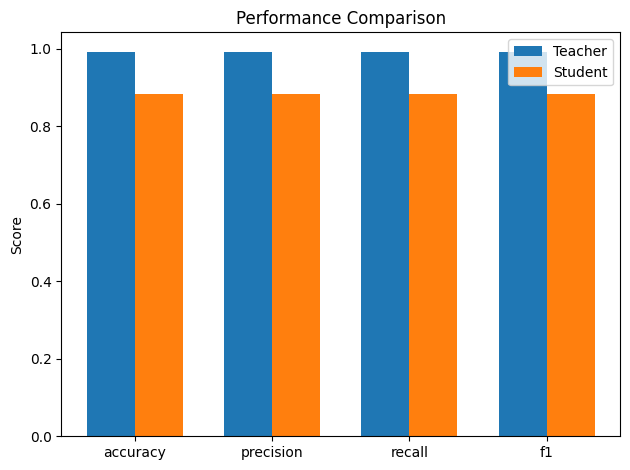

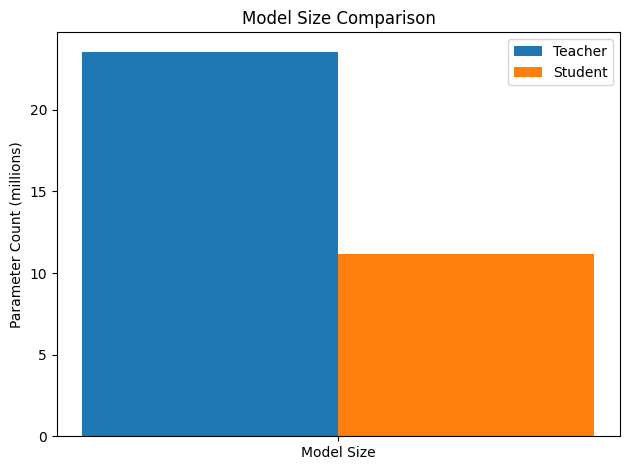

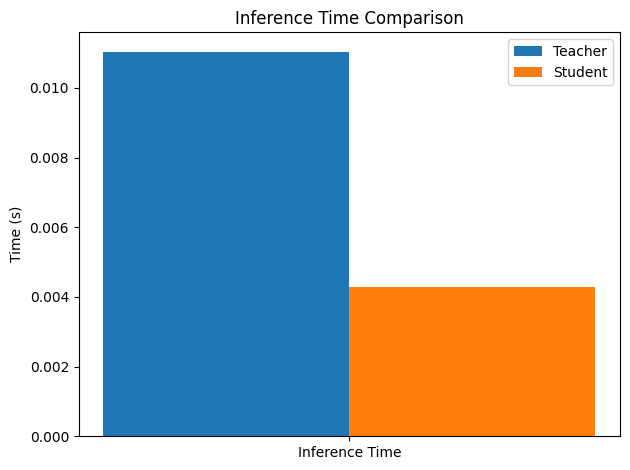

In [22]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

{'accuracy': (0.5319884726224784, 0.4340057636887608), 'precision': (0.5351502105023809, 0.4258296758758739), 'recall': (0.5319884726224784, 0.4340057636887608), 'f1': (0.5295385085537256, 0.4267770745607328)}


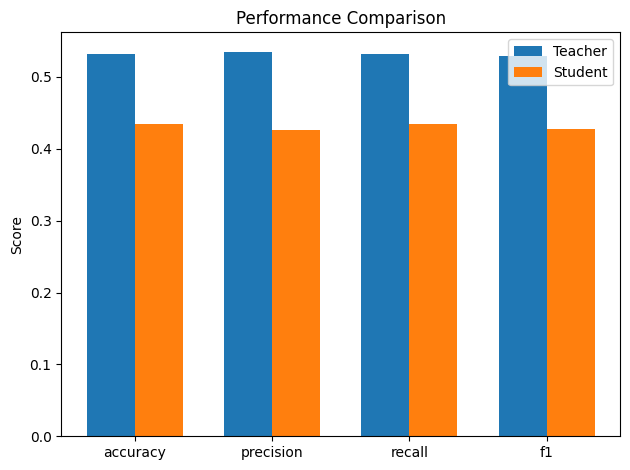

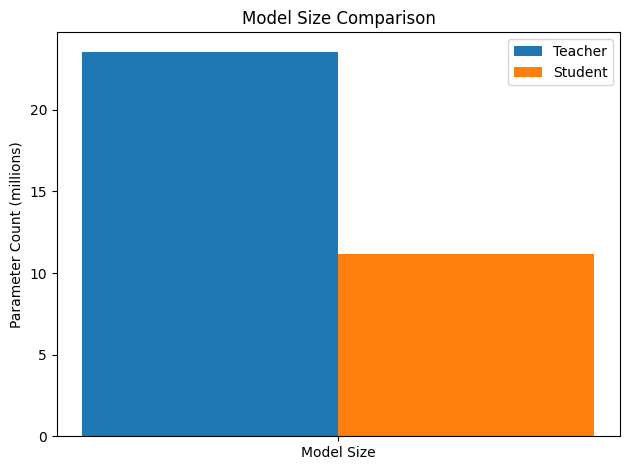

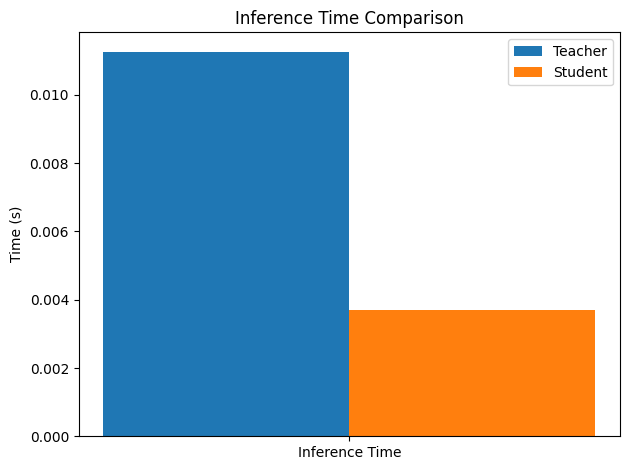

In [23]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')